In [ ]:
"""
Challenge 1: EEG-GPT Foundation Model Training Script for Google Colab
====================================================================

This script implements our EEG-GPT architecture for Challenge 1 (Response Time Prediction)
following the updated competition rules and our hybrid preprocessing approach.

Architecture Design:
- Multi-Scale ViT: Patch sizes [32, 16, 8] for hierarchical pattern capture
- Direct Regression: Simple linear prediction from latent features
- Event-Based Windowing: Precise stimulus alignment using actual event timing
- Memory Efficient: Designed to fit within 20GB GPU constraint

Competition Updates (December 2024):
- Challenge 1: Response time prediction ONLY (no classification)
- Evaluation: Normalized RMSE = rmse(y_true, y_pred) / std(y_true)
- Hardware: Single GPU with 20GB maximum
- Sampling: 100Hz mandatory for submission

Usage in Google Colab:
1. Mount Google Drive
2. Install required packages
3. Run sections sequentially for training
4. Generate submission files

Author: Adolfo Ramirez-Aristizabal
"""

'\nChallenge 1: EEG-GPT Foundation Model Training Script for Google Colab\n====================================================================\n\nThis script implements our EEG-GPT architecture for Challenge 1 (Response Time Prediction)\nfollowing the updated competition rules and our hybrid preprocessing approach.\n\nArchitecture Design:\n- Multi-Scale ViT: Patch sizes [32, 16, 8] for hierarchical pattern capture\n- Direct Regression: Simple linear prediction from latent features\n- Event-Based Windowing: Precise stimulus alignment using actual event timing\n- Memory Efficient: Designed to fit within 20GB GPU constraint\n\nCompetition Updates (December 2024):\n- Challenge 1: Response time prediction ONLY (no classification)\n- Evaluation: Normalized RMSE = rmse(y_true, y_pred) / std(y_true)\n- Hardware: Single GPU with 20GB maximum\n- Sampling: 100Hz mandatory for submission\n\nUsage in Google Colab:\n1. Mount Google Drive\n2. Install required packages\n3. Run sections sequentially f

# SECTION 1: SETUP AND INSTALLATION (Google Colab)

In [ ]:
# Install competition-specific packages for Google Colab

!pip install eegdash braindecode mne>=1.6.0 plotly>=5.17.0 einops>=0.7.0
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers accelerate wandb


# Mount Google Drive (uncomment for Colab)
"""
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project directory (adjust path as needed)
import os
project_path = '/content/drive/My Drive/Neuro_Foundation_Model/Neurips_25_EEG_Foundation_Challenge'
os.chdir(project_path)
print(f"Current directory: {os.getcwd()}")
"""

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
Looking in indexes: https://download.pytorch.org/whl/cu118


'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Navigate to project directory (adjust path as needed)\nimport os\nproject_path = \'/content/drive/My Drive/Neuro_Foundation_Model/Neurips_25_EEG_Foundation_Challenge\'\nos.chdir(project_path)\nprint(f"Current directory: {os.getcwd()}")\n'

# SECTION 2: IMPORT LIBRARIES

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Competition and EEG libraries
from eegdash.dataset import EEGChallengeDataset
from braindecode.preprocessing import preprocess, Preprocessor
import mne
from scipy import signal

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from einops import rearrange, reduce
from sklearn.model_selection import KFold

# Utilities
from tqdm import tqdm
import json
from datetime import datetime
import os
import pickle

# Configure plotting and MNE
plt.style.use('default')
sns.set_palette("husl")
mne.set_log_level('WARNING')

print("All libraries imported successfully!")
print("Ready for Challenge 1 EEG-GPT training")

All libraries imported successfully!
Ready for Challenge 1 EEG-GPT training


# SECTION 3: COMPETITION-ALIGNED DATA LOADING

In [ ]:
def extract_challenge1_response_times(events_df, sfreq):
    """
    Extract response times for Challenge 1: Contrast Change Detection

    According to HBN documentation, Challenge 1 events should include:
    - Stimulus events (target presentations)
    - Response events (left_buttonPress, right_buttonPress)
    - Feedback events (smiley/sad face)

    Args:
        events_df: DataFrame with columns [onset, duration, description]
        sfreq: Sampling frequency

    Returns:
        valid_events: List of dicts with stimulus_onset, response_time, etc.
    """
    # Look for stimulus events (various possible names)
    stimulus_patterns = ["stimulus", "target", "cue", "trial", "change"]
    stimulus_events = events_df[
        events_df.description.str.contains("|".join(stimulus_patterns), case=False, na=False)
    ].copy()

    # Look for response events (button presses)
    response_patterns = ["button", "response", "press", "left", "right"]
    response_events = events_df[
        events_df.description.str.contains("|".join(response_patterns), case=False, na=False)
    ].copy()

    print(f"  Found {len(stimulus_events)} potential stimulus events")
    print(f"  Found {len(response_events)} potential response events")

    if len(stimulus_events) > 0:
        print(f"  Stimulus event types: {sorted(stimulus_events['description'].unique())}")
    if len(response_events) > 0:
        print(f"  Response event types: {sorted(response_events['description'].unique())}")

    # Now implement the actual stimulus-response pairing logic
    valid_events = []

    # Focus on target events as stimuli (left_target, right_target)
    target_events = stimulus_events[
        stimulus_events['description'].str.contains('target', case=False, na=False)
    ]

    # Focus on button press events as responses
    button_events = response_events[
        response_events['description'].str.contains('buttonPress', case=False, na=False)
    ]

    print(f"  Filtering to {len(target_events)} target events and {len(button_events)} button press events")

    if len(target_events) == 0 or len(button_events) == 0:
        print(f"  ⚠️  No target-buttonPress pairs available for pairing")
        return valid_events

    # Pair each target with the next button press within reasonable time window
    for _, target in target_events.iterrows():
        target_time = target['onset']
        target_type = target['description']

        # Find button presses within 0.2-3.0 seconds after target
        candidate_responses = button_events[
            (button_events['onset'] > target_time + 0.2) &
            (button_events['onset'] < target_time + 3.0)
        ]

        if len(candidate_responses) > 0:
            # Take the first (closest) response
            response = candidate_responses.iloc[0]
            response_time = response['onset'] - target_time

            valid_events.append({
                'stimulus_onset': target_time,
                'response_time': response_time,
                'stimulus_type': target_type,
                'response_type': response['description']
            })

    print(f"  ✅ Successfully paired {len(valid_events)} stimulus-response events")
    if valid_events:
        response_times = [e['response_time'] for e in valid_events]
        print(f"  📊 Response time range: {min(response_times):.3f} - {max(response_times):.3f}s")
        print(f"  📊 Mean response time: {np.mean(response_times):.3f}s")

    return valid_events

def load_challenge1_data(task="contrastChangeDetection", release="R5", dataset_size="full", cache_dir="./data"):
    """
    Load Challenge 1 data with competition-aligned preprocessing

    Args:
        task: Task name for data loading
        release: Data release to use
        dataset_size: Dataset size - "full", "medium" (~75%), or "mini" (small subset)
        cache_dir: Cache directory for data

    Returns:
        (dataset, first_raw): Loaded dataset and first raw recording
    """
    print(f"\nLOADING CHALLENGE 1 DATA")
    print("=" * 50)

    # Debug: print the dataset_size being used
    print(f"🔧 Debug: dataset_size = {dataset_size}")

    try:
        # Convert dataset_size to mini parameter for backward compatibility
        if dataset_size == "mini":
            mini = True
            print("🔬 Using mini dataset for testing...")
        elif dataset_size == "full":
            mini = False
            print("📊 Using full dataset...")
        elif dataset_size == "medium":
            mini = False  # Load full first, then subsample
            print("📊 Using medium dataset (~75% of full)...")
        else:
            print(f"⚠️  Unknown dataset_size '{dataset_size}', defaulting to mini")
            mini = True
            dataset_size = "mini"

        # Load dataset using eegdash
        dataset = EEGChallengeDataset(
            task=task,
            release=release,
            cache_dir=cache_dir,
            mini=mini
        )

        # Handle medium dataset by subsampling
        if dataset_size == "medium" and not mini:
            import random
            original_count = len(dataset.datasets)
            medium_count = int(original_count * 0.75)  # 75% of full dataset

            print(f"📊 Subsampling for medium dataset:")
            print(f"   Original recordings: {original_count}")
            print(f"   Medium dataset size: {medium_count}")

            # Reproducible random sampling
            random.seed(42)
            indices = random.sample(range(original_count), medium_count)
            indices.sort()  # Keep chronological order

            # Create subsampled dataset
            dataset.datasets = [dataset.datasets[i] for i in indices]
            print(f"   ✅ Subsampled to {len(dataset.datasets)} recordings")

        print(f"✅ Dataset loaded: {len(dataset.datasets)} recordings")

        # Inspect first recording
        first_raw = dataset.datasets[0].raw
        print(f"📊 Data specs:")
        print(f"   Channels: {first_raw.info['nchan']}")
        print(f"   Original sampling rate: {first_raw.info['sfreq']} Hz")
        print(f"   Duration: {first_raw.times[-1]:.1f} seconds")


        # CRITICAL: Validate we have the right task data
        print(f"\n🔍 DATA VALIDATION:")
        print(f"   Task: {task}")
        print(f"   Release: {release}")
        print(f"   Dataset size: {dataset_size}")

        # Check if we have annotations (events)
        if hasattr(first_raw, "annotations") and len(first_raw.annotations) > 0:
            print(f"   ✅ Annotations found: {len(first_raw.annotations)} events")

            # Show event types in first recording
            events_df = pd.DataFrame({
                "onset": first_raw.annotations.onset,
                "duration": first_raw.annotations.duration,
                "description": first_raw.annotations.description
            })

            unique_events = sorted(events_df.description.unique())
            print(f"   📋 Event types in first recording: {unique_events}")

            # Check for Challenge 1 required events
            has_stimulus = any("stimulus" in evt.lower() or "target" in evt.lower() or "change" in evt.lower() for evt in unique_events)
            has_response = any("button" in evt.lower() or "response" in evt.lower() or "press" in evt.lower() for evt in unique_events)

            print(f"   🎯 Challenge 1 validation:")
            stimulus_status = "YES" if has_stimulus else "NO"
            response_status = "YES" if has_response else "NO"
            print(f"      Stimulus events: {stimulus_status} - {has_stimulus}")
            print(f"      Response events: {response_status} - {has_response}")
            if not has_stimulus or not has_response:
                print(f"   ⚠️  WARNING: Missing required event types for Challenge 1!")
                print(f"      Challenge 1 requires stimulus-response pairs for response time prediction")
                print(f"      Current data may not be suitable for training")
        else:
            print(f"   ❌ No annotations found - this data cannot be used for Challenge 1")
            print(f"      Challenge 1 requires event timing for response time prediction")
        return dataset, first_raw

    except Exception as e:
        print(f"❌ Data loading failed: {e}")
        return None, None

def create_competition_preprocessing_pipeline(original_sfreq, target_sfreq=100):
    """
    Create preprocessing pipeline aligned with competition requirements

    Key points:
    - Adaptive to original sampling rate
    - 100Hz sampling (competition mandatory)
    - Smart line noise filtering based on Nyquist constraints
    - Standard EEG reference and filtering
    """
    print(f"\nCREATING PREPROCESSING PIPELINE")
    print(f"Original sampling rate: {original_sfreq} Hz")
    print(f"Target sampling rate: {target_sfreq} Hz (Competition Standard)")
    print("-" * 40)

    # Calculate Nyquist frequencies
    original_nyquist = original_sfreq / 2
    target_nyquist = target_sfreq / 2

    preprocessors = []

    # Step 1: Initial filtering based on original sampling rate
    if original_sfreq > target_sfreq:
        # High original sampling rate - can do full preprocessing
        print("📊 High sampling rate detected - full preprocessing pipeline")

        # Initial wide bandpass filter
        h_freq_initial = min(200, original_nyquist - 5)
        preprocessors.extend([
            Preprocessor('filter', l_freq=0.1, h_freq=h_freq_initial, verbose=False),
            Preprocessor('notch_filter', freqs=[60], verbose=False),  # Safe with high sampling rate
            Preprocessor('resample', sfreq=target_sfreq, verbose=False),
        ])

        # Final filter after resampling
        preprocessors.append(
            Preprocessor('filter', l_freq=0.5, h_freq=target_nyquist-2, verbose=False)
        )

    elif original_sfreq == target_sfreq:
        # Already at target sampling rate
        print("📊 Already at target sampling rate - simplified preprocessing")

        # Check if we can apply 60Hz notch filter
        if original_nyquist > 60:
            print("   ✅ 60Hz notch filter applicable")
            preprocessors.extend([
                Preprocessor('filter', l_freq=0.5, h_freq=min(45, original_nyquist-2), verbose=False),
                Preprocessor('notch_filter', freqs=[60], verbose=False),
            ])
        else:
            print("   ⚠️  60Hz notch filter NOT applicable (above Nyquist)")
            preprocessors.append(
                Preprocessor('filter', l_freq=0.5, h_freq=original_nyquist-2, verbose=False)
            )

    else:
        # Lower original sampling rate than target (unusual case)
        print("📊 Low original sampling rate - minimal preprocessing")
        preprocessors.extend([
            Preprocessor('filter', l_freq=0.5, h_freq=original_nyquist-2, verbose=False),
            Preprocessor('resample', sfreq=target_sfreq, verbose=False),
        ])

    # Always add reference at the end
    preprocessors.append(
        Preprocessor('set_eeg_reference', ref_channels='average', verbose=False)
    )

    print("\nPipeline created:")
    for i, prep in enumerate(preprocessors):
        fn_name = prep.fn if isinstance(prep.fn, str) else prep.fn.__name__
        print(f"  {i+1}. {fn_name}: {prep.kwargs}")

    print(f"\n📊 Frequency Analysis:")
    print(f"   Original Nyquist frequency: {original_nyquist} Hz")
    print(f"   Target Nyquist frequency: {target_nyquist} Hz")
    if original_nyquist > 60:
        print(f"   60Hz line noise filtering: ✅ Applied")
    else:
        print(f"   60Hz line noise filtering: ❌ Skipped (above Nyquist limit)")

    return preprocessors

def apply_preprocessing(dataset, preprocessors):
    """Apply preprocessing pipeline to dataset"""
    print("\nAPPLYING PREPROCESSING...")

    try:
        preprocess(dataset, preprocessors, n_jobs=1)

        # Verify results
        first_raw = dataset.datasets[0].raw
        print(f"✅ Preprocessing complete:")
        print(f"   Final sampling rate: {first_raw.info['sfreq']} Hz")
        print(f"   Final shape: {first_raw.get_data().shape}")

        return True

    except Exception as e:
        print(f"❌ Preprocessing failed: {e}")
        return False

# SECTION 4: EVENT-BASED WINDOWING FOR CHALLENGE 1

In [ ]:
# This function is deprecated - use extract_challenge1_response_times instead
# Keeping for backward compatibility but it should not be used

def create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100):
    """
    Create event-aligned windows specifically for Challenge 1 response time prediction

    Returns:
    - X: EEG windows (n_samples, n_channels, n_timepoints)
    - y: Response times (n_samples,)
    - metadata: Event information for each window
    """
    print("\nCREATING CHALLENGE 1 WINDOWS")
    print("=" * 40)

    all_windows = []
    all_labels = []
    all_metadata = []
    window_samples = int(window_length * target_sfreq)

    for i, ds in enumerate(dataset.datasets):
        raw = ds.raw
        eeg_data = raw.get_data()  # Shape: (n_channels, n_samples)
        sfreq = raw.info['sfreq']

        print(f"\nProcessing recording {i+1}:")
        print(f"  Duration: {raw.times[-1]:.1f}s, Sampling rate: {sfreq}Hz")

        # Extract events
        if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
            events_df = pd.DataFrame({
                'onset': raw.annotations.onset,
                'duration': raw.annotations.duration,
                'description': raw.annotations.description
            })

            # Extract response times using the correct function
            valid_events = extract_challenge1_response_times(events_df, sfreq)

            # For now, show what events are actually available
            event_types = sorted(events_df.description.unique())
            print(f"Available event types: {event_types}")

            if len(valid_events) == 0:
                print(f"  ❌ ERROR: No valid stimulus-response pairs found in recording {i+1}")
                print(f"     This indicates wrong task data or missing behavioral responses")
                print(f"     Available events: {list(events_df.description.unique())}")
                print(f"     Skipping this recording - cannot train without real response times")
                continue  # Skip this recording instead of using dummy data

            # Create windows aligned with stimulus events
            for event in valid_events:
                stimulus_onset = event['stimulus_onset']
                response_time = event['response_time']

                # Convert to sample indices
                start_sample = int(stimulus_onset * sfreq)
                end_sample = start_sample + window_samples

                # Ensure we don't exceed data bounds
                if end_sample <= eeg_data.shape[1]:
                    window_data = eeg_data[:, start_sample:end_sample]

                    all_windows.append(window_data.T)  # Transpose to (time, channels)
                    all_labels.append(response_time)
                    all_metadata.append({
                        'recording_id': i,
                        'stimulus_onset': stimulus_onset,
                        'response_time': response_time,
                        'stimulus_type': event['stimulus_type'],
                        'response_type': event['response_type']
                    })
        else:
            print(f"  ❌ ERROR: No annotations found in recording {i+1}")
            print(f"     EEG data without events cannot be used for Challenge 1")
            print(f"     Challenge 1 requires stimulus-response event pairs")
            print(f"     Skipping this recording")
            continue  # Skip instead of creating dummy data
    if all_windows:
        X = np.stack(all_windows)  # Shape: (n_samples, n_timepoints, n_channels)
        y = np.array(all_labels)

        print(f"\n✅ Created Challenge 1 dataset:")
        print(f"   Windows: {X.shape} (samples, time, channels)")
        print(f"   Labels: {y.shape} (response times)")
        print(f"   Response time stats: {y.min():.3f} - {y.max():.3f}s (mean: {y.mean():.3f}s)")

        return X, y, all_metadata
    else:
        print("❌ No windows created")
        return None, None, None

# SECTION 5: EEG-GPT ARCHITECTURE IMPLEMENTATION

In [ ]:
class GrayscaleConverter(nn.Module):
    """Convert multi-channel EEG to grayscale image representation"""

    def forward(self, x):
        # x: (batch, n_channels, n_timepoints)
        # Add channel dimension for grayscale: (batch, 1, n_channels, n_timepoints)
        return x.unsqueeze(1)

class PatchEmbedding(nn.Module):
    """
    Convert 2D EEG image to patches with learnable embeddings

    Args:
        patch_size: Size of square patches (e.g., 8, 16, 32)
        embed_dim: Embedding dimension
        img_size: Input image size (channels, timepoints)
    """

    def __init__(self, patch_size=16, embed_dim=512, img_size=(129, 200)):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.img_size = img_size

        # Calculate number of patches
        self.n_patches = (img_size[0] // patch_size) * (img_size[1] // patch_size)

        # Patch projection using convolution
        self.proj = nn.Conv2d(
            in_channels=1,  # Grayscale input
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Learnable position embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches, embed_dim))

    def forward(self, x):
        # x: (batch, 1, channels, timepoints)
        B = x.shape[0]

        # Extract patches: (batch, embed_dim, n_patches_h, n_patches_w)
        x = self.proj(x)

        # Flatten patches: (batch, embed_dim, n_patches)
        x = x.flatten(2)

        # Transpose: (batch, n_patches, embed_dim)
        x = x.transpose(1, 2)

        # Add position embeddings
        x = x + self.pos_embed

        return x

class DualScaleViTEncoder(nn.Module):
    """
    Dual-scale Vision Transformer encoder

    Uses two different patch sizes (32 and 8) to capture both:
    - Coarse-grained patterns (32x32 patches) - global context
    - Fine-grained patterns (8x8 patches) - local details

    Features are processed separately then combined for richer representations.
    """

    def __init__(self, embed_dim=256, num_layers=1, num_heads=2):
        super().__init__()

        self.embed_dim = embed_dim

        # Dual patch embeddings - different scales
        self.coarse_patch_embedding = PatchEmbedding(
            patch_size=32,  # Coarse scale - global patterns
            embed_dim=embed_dim,
            img_size=(129, 200)
        )

        self.fine_patch_embedding = PatchEmbedding(
            patch_size=8,   # Fine scale - local details
            embed_dim=embed_dim,
            img_size=(129, 200)
        )

        # Separate transformers for each scale
        self.coarse_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim,
                dropout=0.2,
                batch_first=True
            ),
            num_layers=num_layers
        )

        self.fine_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim,
                dropout=0.2,
                batch_first=True
            ),
            num_layers=num_layers
        )

        # Scale fusion layer
        self.scale_fusion = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        # x: (batch, 1, 129, 200)

        # Extract patches at both scales
        coarse_patches = self.coarse_patch_embedding(x)  # (batch, n_coarse_patches, embed_dim)
        fine_patches = self.fine_patch_embedding(x)      # (batch, n_fine_patches, embed_dim)

        # Process each scale with residual connections
        coarse_residual = coarse_patches
        coarse_encoded = self.coarse_transformer(coarse_patches)
        coarse_encoded = coarse_encoded + coarse_residual  # Residual connection

        fine_residual = fine_patches
        fine_encoded = self.fine_transformer(fine_patches)
        fine_encoded = fine_encoded + fine_residual  # Residual connection

        # Global average pooling for each scale
        coarse_global = coarse_encoded.mean(dim=1)  # (batch, embed_dim)
        fine_global = fine_encoded.mean(dim=1)      # (batch, embed_dim)

        # Very light inter-scale dropout to prevent co-adaptation (training only)
        if self.training:
            coarse_global = F.dropout(coarse_global, p=0.05, training=True)
            fine_global = F.dropout(fine_global, p=0.05, training=True)

        # Fuse multi-scale features
        combined_features = torch.cat([coarse_global, fine_global], dim=1)  # (batch, embed_dim * 2)
        fused_features = self.scale_fusion(combined_features)  # (batch, embed_dim)

        return fused_features

class LatentCompressor(nn.Module):
    """Compress single-scale features to generalizable latent representation"""

    def __init__(self, input_dim=256, output_dim=128):
        super().__init__()

        # Simplified to single layer with reduced dropout
        self.compressor = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(0.2)  # Reduced dropout for better information flow
        )

    def forward(self, x):
        return self.compressor(x)


class EEGGPTChallenge1(nn.Module):
    """
    Dual-Scale EEG-GPT model for Challenge 1 (Response Time Prediction)

    Enhanced Architecture:
    1. Grayscale conversion (EEG → image)
    2. Dual-scale ViT encoder (patch_sizes: 32 & 8, 1 layer each)
    3. Scale fusion layer (combines coarse + fine features)
    4. Single latent layer (embed_dim → 32)
    5. Direct linear regression (32 → 1)

    Key improvements:
    - Multi-scale pattern capture (global context + local details)
    - Residual connections in transformers
    - Proper weight initialization
    """

    def __init__(self, embed_dim=256):  # Reduced from 512 to 256
        super().__init__()

        # Dual-scale architecture: ViT → Fusion → Latent → Regression
        self.grayscale_converter = GrayscaleConverter()
        self.dual_scale_vit = DualScaleViTEncoder(
            embed_dim=embed_dim,
            num_layers=1,   # Single layer per scale
            num_heads=2     # Keep 2 heads
        )

        # Single latent layer (no compressor, just one linear transformation)
        self.latent_layer = nn.Sequential(
            nn.Linear(embed_dim, 10),  # ViT features → 10 latent features
            nn.ReLU()
        )

        # Direct linear regression (no intermediate layers)
        self.regression = nn.Linear(10, 1)  # 10 → 1 (direct prediction)

        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialize model weights for better training stability

        Key fixes:
        1. Position embeddings: Small variance (std=0.02) instead of std=1.0
        2. Skip connections: Small gain (0.1) to let residuals dominate initially
        3. Proper initialization for different layer types
        """
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Weights: Xavier for linear layers
                nn.init.xavier_uniform_(module.weight)
                # Biases: Zero
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.Conv2d):
                # Weights: He uniform for conv (matching EEG2Mel success)
                nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
                # Biases: Zero
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.LayerNorm):
                # Standard LayerNorm initialization
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
                if module.weight is not None:
                    nn.init.constant_(module.weight, 1.0)

        # CRITICAL FIX: Position embeddings - use small variance instead of std=1.0
        for module in self.modules():
            if hasattr(module, 'pos_embed'):
                print(f"🔧 Fixing position embedding initialization: {module.__class__.__name__}")
                nn.init.normal_(module.pos_embed, std=0.02)  # Much smaller than default std=1.0!

        print("✅ Weight initialization complete!")
        print("   - Position embeddings: std=0.02 (was std=1.0)")
        print("   - Linear layers: Xavier uniform")
        print("   - Conv layers: Kaiming normal")

    def forward(self, x):
        # x: (batch, n_timepoints, n_channels) -> need (batch, n_channels, n_timepoints)
        if x.dim() == 3 and x.shape[1] == 200:  # (batch, time, channels)
            x = x.transpose(1, 2)  # -> (batch, channels, time)

        # Convert to grayscale image
        x_gray = self.grayscale_converter(x)  # (batch, 1, channels, time)

        # Dual-scale ViT encoding
        vit_features = self.dual_scale_vit(x_gray)  # (batch, embed_dim)

        # Single latent layer
        latent_features = self.latent_layer(vit_features)  # (batch, 10)

        # Direct linear regression
        response_time = self.regression(latent_features)  # (batch, 1)

        return response_time  # (batch, 1) - CodeBench expects 2D output

# =============================================================================
# SECTION 5.5: MODULAR ARCHITECTURE SYSTEM
# =============================================================================

class ModelRegistry:
    """Registry for different model architectures"""

    def __init__(self):
        self.models = {}
        self.register_default_models()

    def register_model(self, name, model_class, description=""):
        """Register a new model architecture"""
        self.models[name] = {
            'class': model_class,
            'description': description
        }

    def get_model(self, name, **kwargs):
        """Get model instance by name"""
        if name not in self.models:
            raise ValueError(f"Model {name} not found. Available: {list(self.models.keys())}")

        model_class = self.models[name]['class']
        return model_class(**kwargs)

    def list_models(self):
        """List all available models"""
        print("\n🏗️  AVAILABLE MODEL ARCHITECTURES:")
        print("=" * 50)
        for i, (name, info) in enumerate(self.models.items(), 1):
            print(f"  [{i}] {name}")
            if info['description']:
                print(f"      {info['description']}")
        print("=" * 50)
        return list(self.models.keys())

    def register_default_models(self):
        """Register the two main model architectures"""

        # Current ViT-based model
        self.register_model(
            'transformer_vit',
            EEGGPTChallenge1,
            "Vision Transformer approach - current architecture"
        )

# =============================================================================
# SECTION 5.6: RAW EEG CNN WITH RESIDUAL CONNECTIONS
# =============================================================================

class ResidualBlock(nn.Module):
    """Residual block for raw EEG CNN processing"""

    def __init__(self, in_channels, out_channels, kernel_size=(4, 4), stride=1, dropout=0.1):
        super().__init__()

        # Calculate padding to maintain size compatibility
        if isinstance(kernel_size, tuple):
            kh, kw = kernel_size
        else:
            kh = kw = kernel_size

        # Use explicit padding calculation for all cases to ensure compatibility
        # For stride>1, we need to be more careful about output dimensions
        if stride == 1:
            padding = (kh//2, kw//2)  # same padding
        else:
            # For stride>1, use explicit padding that ensures divisible output
            padding = (kh//2, kw//2)

        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=(kh//2, kw//2))
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection - ensure output dimensions match
        self.skip_conv = None
        if in_channels != out_channels or stride != 1:
            self.skip_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

        # Store stride for dimension matching in forward
        self.stride = stride
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout(out)  # Dropout after first conv

        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection with dimension matching
        if self.skip_conv is not None:
            skip = self.skip_conv(x)
        else:
            skip = x

        # Ensure dimensions match before adding
        if out.shape != skip.shape:
            # Use adaptive pooling to match dimensions
            skip = F.adaptive_avg_pool2d(skip, out.shape[2:])

        # Add skip connection
        out = out + skip
        out = self.relu2(out)

        return out

class RawEEGCNN(nn.Module):
    """
    Raw EEG CNN for response time prediction

    Treats raw EEG as 2D grayscale images [channels, samples, 1]
    Based on EEG2Mel architecture but adapted for:
    1. Raw EEG input (no mel transformation)
    2. Response time regression (not spectrogram reconstruction)
    3. Your specific data format: (batch, time, channels) → (batch, 1, channels, samples)

    Architecture follows EEG2Mel paper:
    - Progressive channel increase: 8→16→32→64→128
    - 4x4 convolutions with BatchNorm
    - Residual connections for better gradient flow
    - MaxPool placement following paper

    Improvements:
    - Light dropout (10%) between CNN layers
    - Overlapping strides for better feature extraction
    - No dropout before final output layer
    - He uniform initialization
    """

    def __init__(self, embed_dim=256, input_channels=129, input_time=200,
                 cnn_dropout=0.1, fc_dropout=0.15):
        super().__init__()

        self.embed_dim = embed_dim
        self.input_channels = input_channels
        self.input_time = input_time

        # Encoder with overlapping strides and light dropout
        self.encoder_blocks = nn.ModuleList([
            # Block 1: 1 → 8 channels
            ResidualBlock(1, 8, kernel_size=(4, 4), stride=1, dropout=cnn_dropout),

            # Block 2: 8 → 16 channels with overlapping stride
            ResidualBlock(8, 16, kernel_size=(4, 4), stride=2, dropout=cnn_dropout),

            # Block 3: 16 → 32 channels with overlapping stride
            ResidualBlock(16, 32, kernel_size=(4, 4), stride=2, dropout=cnn_dropout),

            # Block 4: 32 → 64 channels with overlapping stride
            ResidualBlock(32, 64, kernel_size=(4, 4), stride=2, dropout=cnn_dropout),
        ])

        # Final conv layer with dropout
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(cnn_dropout),  # Light dropout after final conv
        )

        # Simple compression - just MaxPool (following paper exactly)
        self.compression = nn.MaxPool2d(kernel_size=(2, 2))

        # Regression head with controlled dropout
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),

            # Layer 1: 128 → 128 with standard dropout
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),  # 15% dropout for FC layers

            # Layer 2: 128 → 64 (no dropout before final layer)
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            # NO DROPOUT HERE - preserves information for final prediction

            # Output Layer: 64 → 1
            nn.Linear(64, 1)
        )

        # Initialize weights following EEG2Mel paper's He uniform initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights following EEG2Mel paper's He uniform distribution"""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                # He uniform initialization (paper's choice)
                nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        """
        Forward pass for raw EEG data

        Input: (batch, time, channels) - your current format
        Output: (batch,) - response time predictions

        Paper format: [batches, samples, eeg_channels, depth=1]
        PyTorch equivalent: (batch, depth=1, samples, eeg_channels)
        """
        # Convert from your format to paper's CNN format
        # (batch, time, channels) → (batch, 1, time, channels)
        if x.dim() == 3 and x.shape[1] == 200:  # (batch, time=200, channels=129)
            # Add depth dimension: (batch, time, channels) → (batch, 1, time, channels)
            x = x.unsqueeze(1)  # → (batch, 1, time=200, channels=129)

        # Now x has the correct format: (batch, depth=1, samples=200, eeg_channels=129)
        # This matches the paper's TensorFlow format: [batches, samples, eeg_channels, depth=1]

        # Encoder blocks with residual connections
        for block in self.encoder_blocks:
            x = block(x)

        # Final conv layer
        x = self.final_conv(x)

        # Compression layer (following paper's architecture)
        x = self.compression(x)

        # Regression head for response time prediction
        output = self.regression_head(x)

        return output  # (batch, 1) - CodeBench expects 2D output

# Global model registry
model_registry = ModelRegistry()

# Register the raw EEG CNN model
model_registry.register_model(
    'raw_eeg_cnn',
    RawEEGCNN,
    "Raw EEG CNN - treats EEG as 2D grayscale images without mel transformation"
)

# =============================================================================
# SECTION 5.7: GRADIENT MONITORING UTILITIES
# =============================================================================

class GradientMonitor:
    """Monitor gradients to detect vanishing/exploding gradients by layer"""

    def __init__(self, model, track_over_time=False):
        self.model = model
        self.gradient_stats = {}
        self.layer_names = []
        self.track_over_time = track_over_time

        # For time-based tracking
        if track_over_time:
            self.gradient_history = {}
            self.epoch_count = 0

        # Register hooks for all parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.layer_names.append(name)
                param.register_hook(self._make_hook(name))

                if track_over_time:
                    self.gradient_history[name] = {
                        'norms': [],
                        'vanishing_count': 0,
                        'exploding_count': 0,
                        'epochs': []
                    }

    def _make_hook(self, name):
        def hook(grad):
            if grad is not None:
                grad_norm = grad.norm().item()
                grad_mean = grad.mean().item()
                grad_std = grad.std().item()
                grad_max = grad.max().item()
                grad_min = grad.min().item()

                is_vanishing = grad_norm < 1e-6
                is_exploding = grad_norm > 100.0

                self.gradient_stats[name] = {
                    'norm': grad_norm,
                    'mean': grad_mean,
                    'std': grad_std,
                    'max': grad_max,
                    'min': grad_min,
                    'vanishing': is_vanishing,
                    'exploding': is_exploding
                }

                # Track over time if enabled
                if self.track_over_time:
                    self.gradient_history[name]['norms'].append(grad_norm)
                    self.gradient_history[name]['epochs'].append(self.epoch_count)
                    if is_vanishing:
                        self.gradient_history[name]['vanishing_count'] += 1
                    if is_exploding:
                        self.gradient_history[name]['exploding_count'] += 1

        return hook

    def get_gradient_summary(self):
        """Get summary of gradient statistics"""
        if not self.gradient_stats:
            return "No gradient statistics available"

        summary = "\n🔍 GRADIENT ANALYSIS:\n" + "="*50 + "\n"

        # Count problematic gradients
        vanishing_count = sum(1 for stats in self.gradient_stats.values() if stats['vanishing'])
        exploding_count = sum(1 for stats in self.gradient_stats.values() if stats['exploding'])

        summary += f"📊 Overview:\n"
        summary += f"   Total parameters: {len(self.gradient_stats)}\n"
        summary += f"   Vanishing gradients (<1e-6): {vanishing_count}\n"
        summary += f"   Exploding gradients (>100): {exploding_count}\n\n"

        # Show worst offenders
        summary += "🚨 Problematic Layers:\n"

        # Vanishing gradients
        vanishing_layers = [(name, stats) for name, stats in self.gradient_stats.items()
                          if stats['vanishing']]
        if vanishing_layers:
            summary += "   VANISHING GRADIENTS:\n"
            for name, stats in sorted(vanishing_layers, key=lambda x: x[1]['norm'])[:5]:
                summary += f"     • {name}: norm={stats['norm']:.2e}\n"

        # Exploding gradients
        exploding_layers = [(name, stats) for name, stats in self.gradient_stats.items()
                          if stats['exploding']]
        if exploding_layers:
            summary += "   EXPLODING GRADIENTS:\n"
            for name, stats in sorted(exploding_layers, key=lambda x: x[1]['norm'], reverse=True)[:5]:
                summary += f"     • {name}: norm={stats['norm']:.2e}\n"

        # Healthy gradients
        healthy_layers = [(name, stats) for name, stats in self.gradient_stats.items()
                         if not stats['vanishing'] and not stats['exploding']]
        summary += f"\n✅ Healthy gradients: {len(healthy_layers)}\n"

        if healthy_layers:
            # Show gradient norm distribution
            norms = [stats['norm'] for _, stats in healthy_layers]
            summary += f"   Gradient norm range: {min(norms):.2e} - {max(norms):.2e}\n"
            summary += f"   Average gradient norm: {sum(norms)/len(norms):.2e}\n"

        return summary

    def get_layer_specific_analysis(self):
        """Get detailed analysis by model component"""
        if not self.gradient_stats:
            return "No gradient statistics available"

        analysis = "\n🔬 LAYER-SPECIFIC GRADIENT ANALYSIS:\n" + "="*60 + "\n"

        # Group by model component
        components = {
            'ViT Transformers': [],
            'Patch Embeddings': [],
            'Latent Layer': [],
            'Regression': [],
            'Other': []
        }

        for name, stats in self.gradient_stats.items():
            if 'transformer' in name.lower() or 'single_scale_vit' in name:
                components['ViT Transformers'].append((name, stats))
            elif 'patch_embedding' in name:
                components['Patch Embeddings'].append((name, stats))
            elif 'latent_layer' in name:
                components['Latent Layer'].append((name, stats))
            elif 'regression' in name:
                components['Regression'].append((name, stats))
            else:
                components['Other'].append((name, stats))

        for component, layers in components.items():
            if layers:
                analysis += f"\n📍 {component}:\n"
                avg_norm = sum(stats['norm'] for _, stats in layers) / len(layers)
                vanishing = sum(1 for _, stats in layers if stats['vanishing'])
                exploding = sum(1 for _, stats in layers if stats['exploding'])

                analysis += f"   Layers: {len(layers)}\n"
                analysis += f"   Avg gradient norm: {avg_norm:.2e}\n"
                analysis += f"   Vanishing: {vanishing}, Exploding: {exploding}\n"

                if vanishing > 0 or exploding > 0:
                    analysis += "   Problem layers:\n"
                    for name, stats in layers:
                        if stats['vanishing'] or stats['exploding']:
                            status = "VANISHING" if stats['vanishing'] else "EXPLODING"
                            analysis += f"     • {name.split('.')[-1]}: {stats['norm']:.2e} ({status})\n"

        return analysis

    def next_epoch(self):
        """Call this at the start of each epoch when tracking over time"""
        if self.track_over_time:
            self.epoch_count += 1

    def get_compact_summary(self):
        """Get a compact, non-verbose gradient summary"""
        if not self.gradient_stats:
            return "No gradient statistics available"

        vanishing_count = sum(1 for stats in self.gradient_stats.values() if stats['vanishing'])
        exploding_count = sum(1 for stats in self.gradient_stats.values() if stats['exploding'])
        total_params = len(self.gradient_stats)
        healthy_count = total_params - vanishing_count - exploding_count

        # Get worst vanishing layers
        vanishing_layers = [(name, stats['norm']) for name, stats in self.gradient_stats.items() if stats['vanishing']]
        worst_vanishing = sorted(vanishing_layers, key=lambda x: x[1])[:3]  # Top 3 worst

        summary = f"📊 Gradients: {healthy_count}/{total_params} healthy, {vanishing_count} vanishing, {exploding_count} exploding"
        if worst_vanishing:
            worst_names = [name.split('.')[-1] for name, _ in worst_vanishing]
            summary += f" | Worst: {', '.join(worst_names)}"

        return summary

    def get_time_based_analysis(self):
        """Get analysis of gradient trends over time (requires track_over_time=True)"""
        if not self.track_over_time:
            return "Time-based analysis requires track_over_time=True during initialization"

        if self.epoch_count == 0:
            return "No time-based data available yet"

        analysis = "\n📈 GRADIENT TRENDS OVER TIME:\n" + "="*50 + "\n"

        # Overall statistics
        total_layers = len(self.gradient_history)

        # Find layers with worsening vanishing gradients
        worsening_layers = []
        improving_layers = []
        stable_problematic = []

        for name, history in self.gradient_history.items():
            if len(history['norms']) < 2:
                continue

            recent_norms = history['norms'][-5:]  # Last 5 measurements
            early_norms = history['norms'][:5]    # First 5 measurements

            if len(recent_norms) > 0 and len(early_norms) > 0:
                recent_avg = sum(recent_norms) / len(recent_norms)
                early_avg = sum(early_norms) / len(early_norms)

                # Check for trends
                if recent_avg < 1e-6 and early_avg >= 1e-6:
                    worsening_layers.append((name, early_avg, recent_avg))
                elif recent_avg >= 1e-6 and early_avg < 1e-6:
                    improving_layers.append((name, early_avg, recent_avg))
                elif recent_avg < 1e-6 and early_avg < 1e-6:
                    stable_problematic.append((name, recent_avg))

        analysis += f"📊 Layer Trends (over {self.epoch_count} epochs):\n"
        analysis += f"   Total layers monitored: {total_layers}\n"

        if worsening_layers:
            analysis += f"   🔴 Worsening (became vanishing): {len(worsening_layers)}\n"
            for name, early, recent in sorted(worsening_layers, key=lambda x: x[2])[:3]:
                layer_name = name.split('.')[-1]
                analysis += f"     • {layer_name}: {early:.2e} → {recent:.2e}\n"

        if improving_layers:
            analysis += f"   🟢 Improving (recovered): {len(improving_layers)}\n"
            for name, early, recent in sorted(improving_layers, key=lambda x: x[2], reverse=True)[:3]:
                layer_name = name.split('.')[-1]
                analysis += f"     • {layer_name}: {early:.2e} → {recent:.2e}\n"

        if stable_problematic:
            analysis += f"   🟡 Persistently vanishing: {len(stable_problematic)}\n"
            for name, recent in sorted(stable_problematic, key=lambda x: x[1])[:3]:
                layer_name = name.split('.')[-1]
                analysis += f"     • {layer_name}: {recent:.2e}\n"

        # Component-wise analysis
        analysis += "\n🏗️ Component Analysis:\n"
        components = {
            'ViT': [name for name in self.gradient_history.keys() if 'transformer' in name.lower() or 'single_scale_vit' in name],
            'Latent': [name for name in self.gradient_history.keys() if 'latent_layer' in name.lower()],
            'Regression': [name for name in self.gradient_history.keys() if 'regression' in name.lower()],
            'Other': []
        }

        # Assign remaining layers to 'Other'
        assigned = set()
        for comp_layers in components.values():
            assigned.update(comp_layers)
        components['Other'] = [name for name in self.gradient_history.keys() if name not in assigned]

        for comp_name, layer_names in components.items():
            if layer_names:
                vanishing_in_comp = sum(1 for name in layer_names
                                      if self.gradient_history[name]['vanishing_count'] > self.epoch_count * 0.5)
                analysis += f"   {comp_name}: {vanishing_in_comp}/{len(layer_names)} frequently vanishing\n"

        # Recommendations
        analysis += "\n💡 Recommendations:\n"
        if len(worsening_layers) > total_layers * 0.3:
            analysis += "   ⚠️  Many layers developing vanishing gradients - consider lower learning rate\n"
        if len(stable_problematic) > total_layers * 0.5:
            analysis += "   ⚠️  Many persistently vanishing layers - architecture may be too deep\n"
        if len(improving_layers) > 0:
            analysis += "   ✅ Some layers recovering - current strategy may be working\n"

        return analysis

    def reset(self):
        """Clear gradient statistics"""
        self.gradient_stats = {}
        if self.track_over_time:
            self.gradient_history = {name: {'norms': [], 'vanishing_count': 0, 'exploding_count': 0, 'epochs': []}
                                   for name in self.layer_names}
            self.epoch_count = 0

def monitor_gradients_during_training(model, loss, optimizer):
    """
    Monitor gradients during a training step

    Usage:
        loss = criterion(outputs, targets)
        gradient_info = monitor_gradients_during_training(model, loss, optimizer)
        print(gradient_info)
    """
    # Create monitor
    monitor = GradientMonitor(model)

    # Backward pass to compute gradients
    loss.backward()

    # Get gradient analysis
    summary = monitor.get_gradient_summary()
    detailed = monitor.get_layer_specific_analysis()

    return summary + detailed

def analyze_model_gradients(model, train_loader, device='cuda'):
    """
    Standalone function to analyze gradients for debugging

    Usage:
        model = EEGGPTChallenge1()
        train_loader = ... # your training dataloader
        gradient_report = analyze_model_gradients(model, train_loader)
        print(gradient_report)
    """
    model.train()

    # Get first batch
    batch_x, batch_y = next(iter(train_loader))
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    # Create monitor BEFORE forward pass
    monitor = GradientMonitor(model)

    # Forward pass
    model.zero_grad()
    predictions = model(batch_x)
    loss = F.mse_loss(predictions, batch_y)

    # Backward pass (gradients will be captured by monitor hooks)
    loss.backward()

    analysis = "\n" + "="*80 + "\n"
    analysis += "🔍 GRADIENT ANALYSIS REPORT\n"
    analysis += "="*80 + "\n"
    analysis += f"Model: {model.__class__.__name__}\n"
    analysis += f"Batch size: {batch_x.shape[0]}\n"
    analysis += f"Loss: {loss.item():.4f}\n"
    analysis += monitor.get_gradient_summary()
    analysis += monitor.get_layer_specific_analysis()
    analysis += "\n" + "="*80 + "\n"

    return analysis

def test_gradient_monitoring():
    """
    Quick test to verify gradient monitoring works
    Call this after model and dataloaders are created
    """
    print("🧪 Testing gradient monitoring...")
    try:
        # This assumes model and train_loader are in scope
        if 'model' in globals() and 'train_loader' in globals():
            report = analyze_model_gradients(model, train_loader)
            print(report)
            print("✅ Gradient monitoring test successful!")
        else:
            print("❌ model or train_loader not found in global scope")
            print("   Make sure to run this after creating model and dataloaders")
    except Exception as e:
        print(f"❌ Gradient monitoring test failed: {e}")

# SECTION 6: PYTORCH DATASET AND DATALOADER

In [ ]:
class Challenge1Dataset(Dataset):
    """PyTorch Dataset for Challenge 1 response time prediction"""

    def __init__(self, X, y, metadata=None):
        """
        Args:
            X: EEG windows (n_samples, n_timepoints, n_channels)
            y: Response times (n_samples,)
            metadata: Additional information per sample
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.metadata = metadata or [{}] * len(X)

        # Normalize response times to [0, 1] range for better training
        self.y_mean = self.y.mean()
        self.y_std = self.y.std()
        self.y_normalized = (self.y - self.y_mean) / self.y_std

        print(f"Dataset created:")
        print(f"  Samples: {len(self.X)}")
        print(f"  Input shape: {self.X.shape}")
        print(f"  Label stats: mean={self.y_mean:.3f}, std={self.y_std:.3f}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_normalized[idx]

    def denormalize_predictions(self, y_pred_normalized):
        """Convert normalized predictions back to original scale"""
        return y_pred_normalized * self.y_std + self.y_mean

def create_challenge1_dataloaders(X, y, metadata, batch_size=32, train_split=0.8):
    """Create train/validation dataloaders for Challenge 1"""
    print(f"\nCREATING DATALOADERS")
    print("=" * 30)

    # Create dataset
    dataset = Challenge1Dataset(X, y, metadata)

    # Split into train/validation
    n_train = int(len(dataset) * train_split)
    n_val = len(dataset) - n_train

    train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 for Colab compatibility
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    print(f"✅ Dataloaders created:")
    print(f"   Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"   Validation: {len(val_dataset)} samples, {len(val_loader)} batches")
    print(f"   Batch size: {batch_size}")

    return train_loader, val_loader, dataset

def create_cv_dataloaders(X, y, metadata, cv_folds=5, batch_size=32, random_state=42):
    """
    Create cross-validation dataloaders

    Returns:
        list: List of (train_loader, val_loader, train_subset, val_subset) tuples for each fold
    """
    print(f"\n🔄 CREATING {cv_folds}-FOLD CROSS-VALIDATION DATALOADERS")
    print("=" * 50)

    # Create full dataset
    full_dataset = Challenge1Dataset(X, y, metadata)
    n_samples = len(full_dataset)

    # Create KFold splitter
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    cv_dataloaders = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(range(n_samples))):
        print(f"📁 Fold {fold + 1}: Train={len(train_idx)}, Val={len(val_idx)}")

        # Create subset datasets
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)

        # Create dataloaders
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        cv_dataloaders.append((train_loader, val_loader, train_subset, val_subset))

    print(f"✅ Created {cv_folds} cross-validation folds")
    return cv_dataloaders, full_dataset

def create_single_split_dataloaders(X, y, metadata, batch_size=32, train_split=0.8):
    """Original single split for backward compatibility"""
    return create_challenge1_dataloaders(X, y, metadata, batch_size, train_split)

# SECTION 7: TRAINING PIPELINE

In [ ]:
def calculate_normalized_rmse(y_true, y_pred):
    """Calculate normalized RMSE as per competition evaluation"""
    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2))
    y_std = torch.std(y_true)
    return rmse / y_std

class Challenge1Trainer:
    """Training pipeline for Challenge 1 EEG-GPT model"""

    def __init__(self, model, train_loader, val_loader, dataset, device='cuda', monitor_gradients=False, gradient_verbose=True):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.dataset = dataset
        self.device = device
        self.monitor_gradients = monitor_gradients
        self.gradient_verbose = gradient_verbose

        # Initialize gradient monitor for time-based tracking if needed
        self.gradient_monitor = None
        if monitor_gradients and not gradient_verbose:
            self.gradient_monitor = GradientMonitor(self.model, track_over_time=True)
            print("🔍 Gradient monitoring enabled (non-verbose, time-based tracking)")

        # Optimizer and scheduler
        self.optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=100)

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_rmse': [],
            'val_rmse': [],
            'learning_rates': []
        }

        print(f"✅ Trainer initialized on {device}")
        print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_rmse = 0
        n_batches = 0

        # Handle gradient monitoring
        if self.monitor_gradients and self.gradient_verbose:
            # Verbose mode: analyze first batch only
            gradient_monitor = GradientMonitor(self.model)
            print("🔍 Gradient monitoring enabled - will analyze first batch...")
        elif self.monitor_gradients and not self.gradient_verbose:
            # Non-verbose mode: just track for summary
            gradient_monitor = self.gradient_monitor
            gradient_monitor.next_epoch()
        else:
            gradient_monitor = None

        pbar = tqdm(self.train_loader, desc="Training")
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_x)

            # Loss calculation (MSE on normalized targets)
            loss = F.mse_loss(predictions, batch_y)

            # Calculate RMSE on original scale
            with torch.no_grad():
                pred_original = self.dataset.denormalize_predictions(predictions.cpu())
                true_original = self.dataset.denormalize_predictions(batch_y.cpu())
                rmse = torch.sqrt(torch.mean((pred_original - true_original) ** 2))

            # Backward pass
            loss.backward()

            # Handle gradient monitoring
            if gradient_monitor is not None:
                if self.gradient_verbose and n_batches == 0:
                    # Verbose mode: detailed analysis for first batch only
                    gradient_analysis = gradient_monitor.get_gradient_summary() + gradient_monitor.get_layer_specific_analysis()
                    print(gradient_analysis)
                    gradient_monitor = None  # Clear after first batch
                elif not self.gradient_verbose and n_batches == 0:
                    # Non-verbose mode: just show compact summary for first batch
                    compact_summary = gradient_monitor.get_compact_summary()
                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'RMSE': f'{rmse.item():.4f}',
                        'Gradients': compact_summary.split('|')[0].split(':')[1].strip()
                    })
                    # Don't continue - we need to increment n_batches!

            # Gradient clipping removed - let gradients flow freely
            self.optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_rmse += rmse.item()
            n_batches += 1

            # Update progress bar (if not already updated by gradient monitoring)
            if not (gradient_monitor is not None and not self.gradient_verbose and n_batches == 1):  # Changed from n_batches == 0 to n_batches == 1 since we increment before this check
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'RMSE': f'{rmse.item():.4f}'
                })

        return total_loss / n_batches, total_rmse / n_batches

    def get_gradient_summary(self):
        """Get current gradient summary (for non-verbose monitoring)"""
        if self.gradient_monitor is not None:
            return self.gradient_monitor.get_time_based_analysis()
        else:
            return "Gradient monitoring not enabled or not in non-verbose mode"

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        total_rmse = 0
        n_batches = 0

        with torch.no_grad():
            for batch_x, batch_y in self.val_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)

                # Forward pass
                predictions = self.model(batch_x)

                # Loss calculation
                loss = F.mse_loss(predictions, batch_y)

                # RMSE on original scale
                pred_original = self.dataset.denormalize_predictions(predictions.cpu())
                true_original = self.dataset.denormalize_predictions(batch_y.cpu())
                rmse = torch.sqrt(torch.mean((pred_original - true_original) ** 2))

                total_loss += loss.item()
                total_rmse += rmse.item()
                n_batches += 1

        return total_loss / n_batches, total_rmse / n_batches

    def train(self, num_epochs=50, save_path="./models/challenge1_eeg_gpt.pt"):
        """Full training loop"""
        print(f"\nSTARTING TRAINING")
        print("=" * 40)
        print(f"Epochs: {num_epochs}")
        print(f"Device: {self.device}")

        best_val_rmse = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 20)

            # Train and validate
            train_loss, train_rmse = self.train_epoch()
            val_loss, val_rmse = self.validate_epoch()

            # Update scheduler
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_rmse'].append(train_rmse)
            self.history['val_rmse'].append(val_rmse)
            self.history['learning_rates'].append(current_lr)

            # Print metrics
            print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Show gradient summary periodically for non-verbose monitoring
            if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
                if epoch % 10 == 0 or epoch == 1:  # Show at epoch 1 and every 10 epochs
                    print("\n" + "-"*40)
                    print(f"📊 GRADIENT SUMMARY (Epoch {epoch})")
                    print("-"*40)
                    summary = self.gradient_monitor.get_time_based_analysis()
                    print(summary)
                    print("-"*40)

            # Early stopping and model saving
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                patience_counter = 0

                # Save best model
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'val_rmse': val_rmse,
                    'history': self.history
                }, save_path)
                print(f"✅ Best model saved (RMSE: {val_rmse:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered (patience: {patience})")
                    break

        print(f"\n🎉 Training completed!")
        print(f"Best validation RMSE: {best_val_rmse:.4f}")

        # Show comprehensive final gradient analysis if non-verbose monitoring was used
        if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
            print("\n" + "="*70)
            print("📈 COMPREHENSIVE GRADIENT ANALYSIS - TRAINING COMPLETE")
            print("="*70)

            # Training overview
            print(f"🎯 Training Overview:")
            print(f"   Total epochs completed: {epoch}")
            print(f"   Final train RMSE: {train_rmse:.4f}")
            print(f"   Final val RMSE: {val_rmse:.4f}")
            print(f"   Best val RMSE achieved: {best_val_rmse:.4f}")

            # Detailed gradient trends over entire training
            final_summary = self.gradient_monitor.get_time_based_analysis()
            print(final_summary)

            # Training stability assessment
            print("\n🔬 Training Stability Assessment:")
            recent_train_losses = self.history['train_loss'][-5:] if len(self.history['train_loss']) >= 5 else self.history['train_loss']
            recent_val_losses = self.history['val_loss'][-5:] if len(self.history['val_loss']) >= 5 else self.history['val_loss']

            if len(recent_train_losses) > 1:
                train_trend = "decreasing" if recent_train_losses[-1] < recent_train_losses[0] else "increasing"
                val_trend = "decreasing" if recent_val_losses[-1] < recent_val_losses[0] else "increasing"
                print(f"   📉 Recent loss trend - Train: {train_trend}, Val: {val_trend}")

                if train_trend == "decreasing" and val_trend == "decreasing":
                    print("   ✅ Both losses decreasing - healthy training")
                elif train_trend == "decreasing" and val_trend == "increasing":
                    print("   ⚠️  Potential overfitting detected")
                elif train_trend == "increasing":
                    print("   🔴 Training loss increasing - possible gradient issues")

            # Final recommendations
            print(f"\n🎯 Final Training Assessment:")
            improvement = (self.history['val_rmse'][0] - best_val_rmse) / self.history['val_rmse'][0] * 100
            print(f"   📊 Validation RMSE improvement: {improvement:.1f}%")

            if improvement > 10:
                print("   🎉 Excellent training progress!")
            elif improvement > 5:
                print("   ✅ Good training progress")
            elif improvement > 0:
                print("   🟡 Modest improvement - consider longer training")
            else:
                print("   🔴 No improvement - check model/data")

            print("="*70)

        return self.history

# =============================================================================
# SECTION 7.5: CROSS-VALIDATION TRAINER
# =============================================================================

class CrossValidationTrainer:
    """Simplified cross-validation trainer"""

    def __init__(self, model_class, cv_dataloaders, full_dataset, device, params):
        self.model_class = model_class
        self.cv_dataloaders = cv_dataloaders
        self.full_dataset = full_dataset
        self.device = device
        self.params = params
        self.cv_results = []

        # Logging configuration
        self.log_verbosity = params.get('log_verbosity', 'sparse')
        self.log_frequency = params.get('log_frequency', 5)

        print(f"🔄 Cross-validation trainer initialized:")
        print(f"   Folds: {len(cv_dataloaders)}")
        if self.log_frequency > 0:
            print(f"   Logging: {self.log_verbosity} (every {self.log_frequency} epochs)")
        else:
            print(f"   Logging: {self.log_verbosity}")

    def train_cross_validation(self, save_path_template="./models/challenge1_cv_fold_{}.pt"):
        """Simplified cross-validation training - train all folds"""
        print(f"\n🚀 STARTING {len(self.cv_dataloaders)}-FOLD CROSS-VALIDATION")
        print("=" * 60)

        fold_results = []

        for fold, (train_loader, val_loader, train_subset, val_subset) in enumerate(self.cv_dataloaders):
            print(f"\n📁 FOLD {fold + 1}/{len(self.cv_dataloaders)}")
            print("-" * 40)

            # Create fresh model for this fold
            model = self.model_class(embed_dim=self.params['embed_dim'])

            # Create trainer for this fold with custom logging
            trainer = self._create_fold_trainer(model, train_loader, val_loader, fold)

            # Train this fold
            save_path = save_path_template.format(fold + 1)
            history = trainer.train_with_mode(save_path)

            # Store results
            best_val_rmse = min(history['val_rmse'])
            fold_results.append({
                'fold': fold + 1,
                'best_val_rmse': best_val_rmse,
                'final_train_rmse': history['train_rmse'][-1],
                'final_val_rmse': history['val_rmse'][-1],
                'epochs_trained': len(history['train_rmse']),
                'history': history
            })

            # Print fold summary
            self._print_fold_summary(fold + 1, fold_results[-1])

            # Cleanup
            del model, trainer
            torch.cuda.empty_cache()

        # Final comprehensive CV summary (this comes at the end)
        self._print_comprehensive_cv_summary(fold_results)

        self.cv_results = fold_results
        return fold_results

    def _create_fold_trainer(self, model, train_loader, val_loader, fold):
        """Create trainer with custom logging for this fold"""

        # Create base trainer
        trainer = create_interactive_trainer(
            model, train_loader, val_loader, self.full_dataset, self.device, self.params
        )

        # Override epoch methods for custom logging
        if self.log_verbosity == 'minimal':
            trainer = self._wrap_trainer_minimal(trainer, fold)
        elif self.log_frequency > 1:
            trainer = self._wrap_trainer_sparse(trainer, fold)

        return trainer

    def _wrap_trainer_minimal(self, trainer, fold):
        """Wrap trainer to suppress epoch output"""
        original_train_epoch = trainer.train_epoch
        original_validate_epoch = trainer.validate_epoch

        def silent_train_epoch():
            return original_train_epoch()

        def silent_validate_epoch():
            return original_validate_epoch()

        # Replace methods
        trainer.train_epoch = silent_train_epoch
        trainer.validate_epoch = silent_validate_epoch

        return trainer

    def _wrap_trainer_sparse(self, trainer, fold):
        """Wrap trainer for sparse epoch logging"""
        original_train = trainer.train

        def sparse_train(num_epochs=50, save_path="./models/challenge1_eeg_gpt.pt"):
            """Modified training loop with sparse logging"""
            print(f"Training fold {fold + 1} with sparse logging (every {self.log_frequency} epochs)")

            best_val_rmse = float('inf')
            patience = getattr(trainer.params, 'patience', 10) if hasattr(trainer, 'params') else 10
            patience_counter = 0

            for epoch in range(num_epochs):
                # Train and validate (silent)
                train_loss, train_rmse = trainer.train_epoch()
                val_loss, val_rmse = trainer.validate_epoch()
                trainer.scheduler.step()

                # Save metrics
                trainer.history['train_loss'].append(train_loss)
                trainer.history['val_loss'].append(val_loss)
                trainer.history['train_rmse'].append(train_rmse)
                trainer.history['val_rmse'].append(val_rmse)
                trainer.history['learning_rates'].append(trainer.optimizer.param_groups[0]['lr'])

                # Sparse logging
                should_log = (
                    epoch == 0 or  # Always log first epoch
                    (epoch + 1) % self.log_frequency == 0 or  # Every N epochs
                    epoch == num_epochs - 1  # Always log last epoch
                )

                if should_log:
                    current_lr = trainer.optimizer.param_groups[0]['lr']
                    print(f"  E{epoch+1:2d}: TrL={train_loss:.3f} VaL={val_loss:.3f} TrR={train_rmse:.3f} VaR={val_rmse:.3f} LR={current_lr:.1e}")

                # Early stopping logic
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                    trainer.save_checkpoint(epoch, val_rmse, save_path)
                    if should_log:
                        print(f"    ✅ Best model saved (RMSE: {val_rmse:.4f})")
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if not should_log:  # Print final status if we weren't logging this epoch
                            print(f"  E{epoch+1:2d}: TrL={train_loss:.3f} VaL={val_loss:.3f} TrR={train_rmse:.3f} VaR={val_rmse:.3f}")
                        print(f"🛑 Early stopping triggered after {epoch+1} epochs")
                        break

            return trainer.history

        trainer.train = sparse_train
        return trainer

    def _print_fold_summary(self, fold_num, result):
        """Print concise fold summary"""
        print(f"\n📊 FOLD {fold_num} SUMMARY:")
        print(f"   Best Val RMSE: {result['best_val_rmse']:.4f}")
        print(f"   Final Train RMSE: {result['final_train_rmse']:.4f}")
        print(f"   Final Val RMSE: {result['final_val_rmse']:.4f}")
        print(f"   Epochs: {result['epochs_trained']}")

        # Overfitting indicator
        overfitting = result['final_val_rmse'] - result['final_train_rmse']
        if overfitting > 0.1:
            print(f"   ⚠️  Overfitting: {overfitting:.4f}")
        elif overfitting > 0.05:
            print(f"   🟡 Mild overfitting: {overfitting:.4f}")
        else:
            print(f"   ✅ Good generalization: {overfitting:.4f}")

    def _print_comprehensive_cv_summary(self, fold_results):
        """
        Comprehensive cross-validation summary - ONLY at the end
        This is where all the detailed statistics come together
        """
        print(f"\n" + "="*80)
        print("🏆 COMPREHENSIVE CROSS-VALIDATION RESULTS")
        print("="*80)

        # Extract all metrics
        val_rmses = [r['best_val_rmse'] for r in fold_results]
        train_rmses = [r['final_train_rmse'] for r in fold_results]
        final_val_rmses = [r['final_val_rmse'] for r in fold_results]
        epochs_trained = [r['epochs_trained'] for r in fold_results]

        # 1. VALIDATION PERFORMANCE ANALYSIS
        print(f"\n📊 VALIDATION PERFORMANCE:")
        mean_val = np.mean(val_rmses)
        std_val = np.std(val_rmses)
        print(f"   Best RMSE per fold: {val_rmses}")
        print(f"   Mean ± Std: {mean_val:.4f} ± {std_val:.4f}")
        print(f"   Range: {min(val_rmses):.4f} - {max(val_rmses):.4f}")
        print(f"   Best fold: #{np.argmin(val_rmses) + 1} (RMSE: {min(val_rmses):.4f})")
        print(f"   Worst fold: #{np.argmax(val_rmses) + 1} (RMSE: {max(val_rmses):.4f})")

        # 2. MODEL STABILITY ANALYSIS
        print(f"\n📊 MODEL STABILITY:")
        cv_coefficient = std_val / mean_val
        print(f"   Coefficient of Variation: {cv_coefficient:.4f}")
        if cv_coefficient < 0.05:
            stability_status = "✅ Very stable"
        elif cv_coefficient < 0.10:
            stability_status = "🟡 Reasonably stable"
        else:
            stability_status = "⚠️  High variance"
        print(f"   Stability: {stability_status}")

        # 3. GENERALIZATION ANALYSIS
        print(f"\n📊 GENERALIZATION:")
        mean_train = np.mean(train_rmses)
        mean_final_val = np.mean(final_val_rmses)
        generalization_gap = mean_final_val - mean_train
        print(f"   Mean train RMSE: {mean_train:.4f}")
        print(f"   Mean final val RMSE: {mean_final_val:.4f}")
        print(f"   Generalization gap: {generalization_gap:.4f}")

        if generalization_gap < 0.05:
            gen_status = "✅ Excellent generalization"
        elif generalization_gap < 0.10:
            gen_status = "🟡 Good generalization"
        else:
            gen_status = "⚠️  Potential overfitting"
        print(f"   Assessment: {gen_status}")

        # 4. TRAINING EFFICIENCY
        print(f"\n📊 TRAINING EFFICIENCY:")
        mean_epochs = np.mean(epochs_trained)
        print(f"   Epochs per fold: {epochs_trained}")
        print(f"   Mean epochs: {mean_epochs:.1f}")
        print(f"   Total training time: ~{sum(epochs_trained)} epoch-equivalents")

        # 5. COMPETITION READINESS
        print(f"\n🏆 COMPETITION READINESS:")
        print(f"   Estimated competition score: {mean_val:.4f}")
        print(f"   Model consistency: {std_val:.4f}")

        if mean_val < 0.85:  # Example threshold
            readiness = "🎯 Competition ready!"
        elif mean_val < 1.0:
            readiness = "🟡 Good progress, continue tuning"
        else:
            readiness = "📈 Needs improvement"
        print(f"   Assessment: {readiness}")

        # 6. RECOMMENDATIONS
        print(f"\n💡 RECOMMENDATIONS:")
        if cv_coefficient > 0.10:
            print(f"   • High variance detected - consider regularization or more data")
        if generalization_gap > 0.10:
            print(f"   • Overfitting detected - reduce model complexity or add regularization")
        if mean_epochs < 10:
            print(f"   • Early stopping may be too aggressive - consider longer patience")
        elif mean_epochs > 40:
            print(f"   • Training may be inefficient - consider higher learning rate")

        best_fold = np.argmin(val_rmses)
        print(f"   • Use fold #{best_fold + 1} model for final submission")

        print("="*80)

        return {
            'mean_val_rmse': mean_val,
            'std_val_rmse': std_val,
            'best_fold': best_fold + 1,
            'stability_coefficient': cv_coefficient,
            'generalization_gap': generalization_gap
        }

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # RMSE curves
    axes[0, 1].plot(history['train_rmse'], label='Train RMSE')
    axes[0, 1].plot(history['val_rmse'], label='Validation RMSE')
    axes[0, 1].set_title('RMSE Curves')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('RMSE (seconds)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning rate
    axes[1, 0].plot(history['learning_rates'])
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True)

    # Final metrics
    final_train_rmse = history['train_rmse'][-1]
    final_val_rmse = history['val_rmse'][-1]
    best_val_rmse = min(history['val_rmse'])

    axes[1, 1].bar(['Train RMSE', 'Val RMSE', 'Best Val RMSE'],
                   [final_train_rmse, final_val_rmse, best_val_rmse])
    axes[1, 1].set_title('Final Performance')
    axes[1, 1].set_ylabel('RMSE (seconds)')

    plt.tight_layout()
    plt.show()

    print(f"Training Summary:")
    print(f"  Final Train RMSE: {final_train_rmse:.4f}s")
    print(f"  Final Val RMSE: {final_val_rmse:.4f}s")
    print(f"  Best Val RMSE: {best_val_rmse:.4f}s")

# SECTION 8: COMPETITION SUBMISSION TEMPLATE

In [ ]:
class Challenge1Submission:
    """
    Competition submission template for Challenge 1

    This class matches the required submission interface
    """

    def __init__(self, SFREQ, DEVICE):
        self.sfreq = SFREQ  # Will be 100 Hz
        self.device = DEVICE

        # Load the trained model
        self.model = self._load_model()

    def _load_model(self):
        """Load the trained EEG-GPT model"""
        model = EEGGPTChallenge1(embed_dim=512)

        # Load weights (this path will be updated with actual model)
        try:
            checkpoint = torch.load('./models/challenge1_eeg_gpt.pt', map_location=self.device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Model loaded successfully")
        except FileNotFoundError:
            print("⚠️  Model weights not found, using random initialization")

        model.to(self.device)
        model.eval()
        return model

    def get_model_challenge_1(self):
        """
        Return model for Challenge 1 (Response Time Prediction)

        Expected:
        - Input: (batch_size, 129, 200) - EEG data
        - Output: (batch_size, 1) - response time predictions
        """
        return Challenge1SubmissionWrapper(self.model)

class Challenge1SubmissionWrapper(nn.Module):
    """Wrapper to match exact submission interface"""

    def __init__(self, eeg_gpt_model):
        super().__init__()
        self.eeg_gpt = eeg_gpt_model

    def forward(self, x):
        # x: (batch_size, 129, 200)
        # EEG-GPT expects: (batch_size, 200, 129)
        x_transposed = x.transpose(1, 2)

        # Get predictions
        predictions = self.eeg_gpt(x_transposed)

        # Ensure output shape is (batch_size, 1)
        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(-1)

        return predictions

def create_submission_files(model_path="./models/challenge1_eeg_gpt.pt"):
    """Create submission files for the competition"""
    print("CREATING SUBMISSION FILES")
    print("=" * 40)

    # Create submission directory
    os.makedirs("./submission", exist_ok=True)

    # 1. Copy model weights
    import shutil
    if os.path.exists(model_path):
        shutil.copy(model_path, "./submission/weights_challenge_1.pt")
        print("✅ Model weights copied")
    else:
        print("⚠️  Model weights not found")

    # 2. Create submission.py
    submission_code = '''
import torch
import torch.nn as nn

# [Include the complete EEGGPTChallenge1 class definition here]
# [Include the Challenge1Submission and Challenge1SubmissionWrapper classes here]

class Submission:
    def __init__(self, SFREQ, DEVICE):
        self.sfreq = SFREQ
        self.device = DEVICE
        self.challenge1_submission = Challenge1Submission(SFREQ, DEVICE)

    def get_model_challenge_1(self):
        return self.challenge1_submission.get_model_challenge_1()

    def get_model_challenge_2(self):
        # Placeholder for Challenge 2
        return None
'''

    with open("./submission/submission.py", "w") as f:
        f.write(submission_code)

    print("✅ Submission template created")
    print("\nSubmission files:")
    print("  📁 ./submission/")
    print("  ├── submission.py")
    print("  └── weights_challenge_1.pt")

# SECTION 9: MAIN EXECUTION FUNCTION

In [ ]:
def run_challenge1_training(task="contrastChangeDetection", release="R5", mini=True,
                          num_epochs=50, batch_size=32, embed_dim=512):
    """
    Complete Challenge 1 training pipeline

    Parameters:
    - task: Competition task name
    - release: Data release
    - mini: Use mini dataset for testing
    - num_epochs: Training epochs
    - batch_size: Batch size
    - embed_dim: Model embedding dimension
    """
    print("🚀 CHALLENGE 1: EEG-GPT TRAINING PIPELINE")
    print("=" * 60)
    print(f"Task: {task}")
    print(f"Release: {release}")
    print(f"Mini dataset: {mini}")
    print(f"Epochs: {num_epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Embed dim: {embed_dim}")

    # Step 1: Load data
    print("\n" + "="*60)
    print("STEP 1: DATA LOADING")
    dataset, first_raw = load_challenge1_data(task=task, release=release, mini=mini)
    if dataset is None:
        print("❌ Data loading failed")
        return None

    # Step 2: Preprocessing
    print("\n" + "="*60)
    print("STEP 2: PREPROCESSING")
    original_sfreq = first_raw.info['sfreq']
    preprocessors = create_competition_preprocessing_pipeline(original_sfreq=original_sfreq, target_sfreq=100)
    preprocessing_success = apply_preprocessing(dataset, preprocessors)
    if not preprocessing_success:
        print("❌ Preprocessing failed")
        return None

    # Step 3: Create windows and labels
    print("\n" + "="*60)
    print("STEP 3: WINDOWING AND LABEL EXTRACTION")
    X, y, metadata = create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100)
    if X is None:
        print("❌ Windowing failed")
        return None

    # Step 4: Create dataloaders
    print("\n" + "="*60)
    print("STEP 4: DATALOADER CREATION")
    train_loader, val_loader, challenge1_dataset = create_challenge1_dataloaders(
        X, y, metadata, batch_size=batch_size
    )

    # Step 5: Initialize model
    print("\n" + "="*60)
    print("STEP 5: MODEL INITIALIZATION")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = EEGGPTChallenge1(embed_dim=embed_dim)
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Step 6: Training
    print("\n" + "="*60)
    print("STEP 6: TRAINING")
    trainer = Challenge1Trainer(model, train_loader, val_loader, challenge1_dataset, device)
    history = trainer.train(num_epochs=num_epochs)

    # Step 7: Visualize results
    print("\n" + "="*60)
    print("STEP 7: RESULTS VISUALIZATION")
    plot_training_history(history)

    # Step 8: Create submission
    print("\n" + "="*60)
    print("STEP 8: SUBMISSION PREPARATION")
    create_submission_files("./models/challenge1_eeg_gpt.pt")

    print("\n🎉 CHALLENGE 1 TRAINING COMPLETE!")
    print("=" * 60)

    results = {
        'model': model,
        'history': history,
        'dataset': challenge1_dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'device': device
    }

    return results

# SELECTIVE WEIGHT DECAY OPTIMIZER

In [ ]:
def create_selective_optimizer(model, lr=1e-4, weight_decay=1e-5, use_weight_decay=True):
    """
    Create optimizer with selective weight decay applied only to linear layers

    Parameters:
    - model: The neural network model
    - lr: Learning rate
    - weight_decay: Weight decay strength
    - use_weight_decay: Whether to use weight decay at all

    Returns:
    - optimizer: AdamW optimizer with selective weight decay
    """

    if not use_weight_decay:
        # No weight decay at all
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.0)
        print(f"✅ Optimizer created: lr={lr}, no weight decay")
        return optimizer

    # Parameters WITH weight decay (linear layers only)
    decay_params = []
    # Parameters WITHOUT weight decay
    no_decay_params = []

    print(f"\n📋 Weight Decay Assignment:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        # Apply weight decay ONLY to linear layer weights (not biases)
        if 'weight' in name and any(layer_type in name for layer_type in [
            'Linear',           # Explicit linear layers
            'regression',       # Regression layers
            'proj',            # Projection layers
            'fc',              # Fully connected layers
        ]):
            # Additional check: skip if it's a bias or very small layer
            if 'bias' not in name and param.numel() > 100:  # Skip tiny layers
                decay_params.append(param)
                print(f"  ✅ {name}: {param.numel():,} params (WITH weight decay)")
            else:
                no_decay_params.append(param)
                print(f"  ⚪ {name}: {param.numel():,} params (no decay - bias/small)")
        else:
            no_decay_params.append(param)
            if param.numel() > 1000:  # Only show large layers
                print(f"  ⚪ {name}: {param.numel():,} params (no decay - not linear)")

    # Create parameter groups
    optimizer_params = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_params, lr=lr)

    total_with_decay = sum(p.numel() for p in decay_params)
    total_without_decay = sum(p.numel() for p in no_decay_params)

    print(f"\n📊 Weight Decay Summary:")
    print(f"  WITH decay: {total_with_decay:,} parameters ({total_with_decay/(total_with_decay+total_without_decay)*100:.1f}%)")
    print(f"  WITHOUT decay: {total_without_decay:,} parameters ({total_without_decay/(total_with_decay+total_without_decay)*100:.1f}%)")
    print(f"  Weight decay strength: {weight_decay}")

    return optimizer

# INTERACTIVE TRAINING FUNCTIONS

In [ ]:
def get_training_parameters():
    """
    Interactive function to get training parameters from user
    """
    print("\n" + "="*70)
    print("🎛️  INTERACTIVE TRAINING PARAMETER SELECTION")
    print("="*70)

    params = {}

    # Dataset parameters
    print("\n📊 DATASET PARAMETERS:")
    print("-" * 30)

    # Dataset size - UPDATED TO INCLUDE MEDIUM OPTION
    while True:
        dataset_choice = input("Dataset size [full/medium/mini] (default: mini): ").strip().lower()
        if dataset_choice in ['', 'mini']:
            params['dataset_size'] = 'mini'
            params['mini'] = True  # For backward compatibility
            print("   ✅ Mini dataset selected (fastest, good for testing)")
            break
        elif dataset_choice == 'medium':
            params['dataset_size'] = 'medium'
            params['mini'] = False  # For backward compatibility
            print("   ✅ Medium dataset selected (~75% of full, balanced)")
            break
        elif dataset_choice == 'full':
            params['dataset_size'] = 'full'
            params['mini'] = False  # For backward compatibility
            print("   ✅ Full dataset selected (slowest, best performance)")
            break
        else:
            print("   ❌ Please enter 'full', 'medium', or 'mini'")

    # Batch size
    while True:
        try:
            batch_input = input("Batch size [8/16/32/64] (default: 16): ").strip()
            if batch_input == '':
                params['batch_size'] = 16
                break
            batch_size = int(batch_input)
            if batch_size in [8, 16, 32, 64]:
                params['batch_size'] = batch_size
                break
            else:
                print("   ⚠️  Recommended: 8, 16, 32, or 64. Using anyway...")
                params['batch_size'] = batch_size
                break
        except ValueError:
            print("   ❌ Please enter a valid number")

    print(f"   ✅ Batch size: {params['batch_size']}")

    # Model architecture selection
    print("\n🏗️  MODEL ARCHITECTURE SELECTION:")
    print("-" * 40)

    # Show available models
    available_models = model_registry.list_models()

    while True:
        try:
            model_choice = input(f"Select model [1-{len(available_models)}] (default: 1): ").strip()
            if model_choice == '':
                model_choice = 1
            else:
                model_choice = int(model_choice)

            if 1 <= model_choice <= len(available_models):
                selected_model = available_models[model_choice - 1]
                params['model_architecture'] = selected_model
                print(f"   ✅ Selected: {selected_model}")
                break
            else:
                print(f"   ❌ Please enter a number between 1 and {len(available_models)}")
        except ValueError:
            print("   ❌ Please enter a valid number")

    # Model parameters (conditional based on architecture)
    print("\n🏗️  MODEL PARAMETERS:")
    print("-" * 30)

    # Embedding dimension (only for transformer models)
    if params["model_architecture"] == "transformer_vit":
        while True:
            try:
                embed_input = input("Embedding dimension [256/512/768/1024] (default: 512): ").strip()
                if embed_input == "":
                    params["embed_dim"] = 512
                    break
                embed_dim = int(embed_input)
                if embed_dim in [256, 512, 768, 1024]:
                    params["embed_dim"] = embed_dim
                    break
                else:
                    print("   ⚠️  Recommended: 256, 512, 768, or 1024. Using anyway...")
                    params["embed_dim"] = embed_dim
                    break
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ Embedding dimension: {params['embed_dim']}")

    elif params["model_architecture"] == "raw_eeg_cnn":
        # CNN doesnt use embedding dimension, set a default
        params["embed_dim"] = 256  # Default value (not used by CNN)
        print("   ✅ CNN model selected - no embedding dimension needed")

        # CNN-specific parameters
        while True:
            try:
                cnn_dropout_input = input("CNN dropout rate [0.05/0.1/0.15/0.2] (default: 0.1): ").strip()
                if cnn_dropout_input == "":
                    params["cnn_dropout"] = 0.1
                    break
                cnn_dropout = float(cnn_dropout_input)
                if 0.0 <= cnn_dropout <= 0.5:
                    params["cnn_dropout"] = cnn_dropout
                    break
                else:
                    print("   ⚠️  Dropout should be between 0.0 and 0.5")
            except ValueError:
                print("   ❌ Please enter a valid number")

        while True:
            try:
                fc_dropout_input = input("FC dropout rate [0.1/0.15/0.2/0.25] (default: 0.15): ").strip()
                if fc_dropout_input == "":
                    params["fc_dropout"] = 0.15
                    break
                fc_dropout = float(fc_dropout_input)
                if 0.0 <= fc_dropout <= 0.5:
                    params["fc_dropout"] = fc_dropout
                    break
                else:
                    print("   ⚠️  Dropout should be between 0.0 and 0.5")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ CNN dropout: {params['cnn_dropout']}, FC dropout: {params['fc_dropout']}")

    else:
        # Default fallback
        params["embed_dim"] = 512
        print(f"   ✅ Default embedding dimension: {params['embed_dim']}")

    # Training parameters
    print("\n🚀 TRAINING PARAMETERS:")
    print("-" * 30)

    # Training mode
    while True:
        print("\nTraining mode options:")
        print("  [1] Early Stopping (automatic, stops when no improvement)")
        print("  [2] Manual Epochs (train for exact number of epochs)")
        print("  [3] Interactive (train in batches, you control when to stop)")

        mode_choice = input("Select training mode [1/2/3] (default: 1): ").strip()

        if mode_choice in ['', '1']:
            params['training_mode'] = 'early_stopping'
            print("   ✅ Early stopping mode selected")
            break
        elif mode_choice == '2':
            params['training_mode'] = 'manual_epochs'
            print("   ✅ Manual epochs mode selected")
            break
        elif mode_choice == '3':
            params['training_mode'] = 'interactive'
            print("   ✅ Interactive mode selected")
            break
        else:
            print("   ❌ Please enter 1, 2, or 3")

    # Number of epochs (depends on mode)
    if params['training_mode'] == 'early_stopping':
        while True:
            try:
                epochs_input = input("Maximum epochs (early stopping limit) [20/50/100] (default: 50): ").strip()
                if epochs_input == '':
                    params['num_epochs'] = 50
                    break
                params['num_epochs'] = int(epochs_input)
                break
            except ValueError:
                print("   ❌ Please enter a valid number")

        # Patience for early stopping
        while True:
            try:
                patience_input = input("Early stopping patience [5/10/15] (default: 10): ").strip()
                if patience_input == '':
                    params['patience'] = 10
                    break
                params['patience'] = int(patience_input)
                break
            except ValueError:
                print("   ❌ Please enter a valid number")

    elif params['training_mode'] == 'manual_epochs':
        while True:
            try:
                epochs_input = input("Number of epochs to train [5/10/20/50] (default: 20): ").strip()
                if epochs_input == '':
                    params['num_epochs'] = 20
                    break
                params['num_epochs'] = int(epochs_input)
                break
            except ValueError:
                print("   ❌ Please enter a valid number")

    else:  # interactive mode
        while True:
            try:
                epochs_input = input("Initial epochs to train [5/10/15] (default: 10): ").strip()
                if epochs_input == '':
                    params['num_epochs'] = 10
                    break
                params['num_epochs'] = int(epochs_input)
                break
            except ValueError:
                print("   ❌ Please enter a valid number")

    # Learning rate
    while True:
        try:
            lr_input = input("Learning rate [1e-3/1e-4/1e-5] (default: 1e-4): ").strip()
            if lr_input == '':
                params['learning_rate'] = 1e-4
                break
            params['learning_rate'] = float(lr_input)
            break
        except ValueError:
            print("   ❌ Please enter a valid number (e.g., 0.0001 or 1e-4)")

    print(f"   ✅ Learning rate: {params['learning_rate']}")

    # Weight decay
    while True:
        use_wd = input("Use weight decay regularization? [y/n] (default: y): ").strip().lower()
        if use_wd in ['', 'y', 'yes']:
            params['use_weight_decay'] = True
            print("   ✅ Weight decay enabled (applied only to linear layers)")

            # Get weight decay value
            while True:
                try:
                    wd_input = input("   Weight decay strength [1e-4/1e-5/1e-6] (default: 1e-5): ").strip()
                    if wd_input == '':
                        params['weight_decay'] = 1e-5
                        break
                    params['weight_decay'] = float(wd_input)
                    break
                except ValueError:
                    print("   ❌ Please enter a valid number")
            print(f"   ✅ Weight decay: {params['weight_decay']} (linear layers only)")
            break

        elif use_wd in ['n', 'no']:
            params['use_weight_decay'] = False
            params['weight_decay'] = 0.0
            print("   ✅ No weight decay (faster training, may overfit)")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # NEW: Cross-validation parameters
    print("\n🔄 CROSS-VALIDATION PARAMETERS:")
    print("-" * 30)

    while True:
        cv_choice = input("Use cross-validation? [y/n] (default: n): ").strip().lower()
        if cv_choice in ['', 'n', 'no']:
            params['use_cross_validation'] = False
            params['cv_folds'] = 1
            print("   ✅ Single train/validation split (80/20)")
            break
        elif cv_choice in ['y', 'yes']:
            params['use_cross_validation'] = True
            print("   ✅ Cross-validation enabled")

            # Number of folds
            while True:
                try:
                    folds_input = input("Number of CV folds [3/5/10] (default: 5): ").strip()
                    if folds_input == '':
                        params['cv_folds'] = 5
                        break
                    folds = int(folds_input)
                    if folds >= 2:
                        params['cv_folds'] = folds
                        break
                    else:
                        print("   ❌ Need at least 2 folds")
                except ValueError:
                    print("   ❌ Please enter a valid number")

            print(f"   ✅ {params['cv_folds']}-fold cross-validation")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # Enhanced logging parameters
    print("\n📊 LOGGING PARAMETERS:")
    print("-" * 30)

    while True:
        print("\nLogging verbosity:")
        print("  [1] Minimal (fold summaries only)")
        print("  [2] Sparse (every 5th epoch)")
        print("  [3] Moderate (every 2nd epoch)")
        print("  [4] Detailed (every epoch)")

        log_choice = input("Select verbosity [1/2/3/4] (default: 2): ").strip()

        if log_choice in ['', '2']:
            params['log_verbosity'] = 'sparse'
            params['log_frequency'] = 5
            print("   ✅ Sparse logging - every 5th epoch")
            break
        elif log_choice == '1':
            params['log_verbosity'] = 'minimal'
            params['log_frequency'] = 0  # No epoch logging
            print("   ✅ Minimal logging - fold summaries only")
            break
        elif log_choice == '3':
            params['log_verbosity'] = 'moderate'
            params['log_frequency'] = 2
            print("   ✅ Moderate logging - every 2nd epoch")
            break
        elif log_choice == '4':
            params['log_verbosity'] = 'detailed'
            params['log_frequency'] = 1
            print("   ✅ Detailed logging - every epoch")
            break
        else:
            print("   ❌ Please enter 1, 2, 3, or 4")

    # Optional: Custom frequency
    if params['log_verbosity'] not in ['minimal', 'detailed']:
        custom_freq = input(f"Custom frequency (default: {params['log_frequency']}): ").strip()
        if custom_freq.isdigit():
            params['log_frequency'] = int(custom_freq)
            print(f"   ✅ Custom frequency: every {params['log_frequency']} epochs")

    # Gradient monitoring (for debugging)
    while True:
        monitor_input = input("Monitor gradients for debugging? [y/n] (default: n): ").strip().lower()
        if monitor_input == '' or monitor_input in ['n', 'no']:
            params['monitor_gradients'] = False
            params['gradient_verbose'] = True  # Default doesn't matter
            print("   ✅ Gradient monitoring: OFF")
            break
        elif monitor_input in ['y', 'yes']:
            params['monitor_gradients'] = True
            print("   ✅ Gradient monitoring: ON")

            # Ask for verbosity level
            while True:
                verbose_input = input("   Verbose gradient output? [y/n] (default: n): ").strip().lower()
                if verbose_input == '' or verbose_input in ['n', 'no']:
                    params['gradient_verbose'] = False
                    print("   ✅ Non-verbose mode: compact summaries + final time-based analysis")
                    break
                elif verbose_input in ['y', 'yes']:
                    params['gradient_verbose'] = True
                    print("   ✅ Verbose mode: detailed analysis every epoch (can be very long)")
                    break
                else:
                    print("   ❌ Please enter 'y' or 'n'")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # Summary
    print("\n" + "="*70)
    print("📋 TRAINING CONFIGURATION SUMMARY")
    print("="*70)
    print(f"Dataset: {params['dataset_size'].capitalize()}")
    print(f"Model architecture: {params['model_architecture']}")
    print(f"Batch size: {params['batch_size']}")
    print(f"Embedding dimension: {params['embed_dim']}")

    # Cross-validation info
    if params['use_cross_validation']:
        print(f"Validation: {params['cv_folds']}-fold cross-validation")
        if params['log_frequency'] > 0:
            print(f"Logging: {params['log_verbosity']} (every {params['log_frequency']} epochs)")
        else:
            print(f"Logging: {params['log_verbosity']}")
    else:
        print(f"Validation: Single 80/20 split")
    print(f"Training mode: {params['training_mode']}")
    print(f"Epochs: {params['num_epochs']}")
    if 'patience' in params:
        print(f"Early stopping patience: {params['patience']}")

    print(f"Learning rate: {params['learning_rate']}")
    if params['use_weight_decay']:
        print(f"Weight decay: {params['weight_decay']} (linear layers only)")
    else:
        print(f"Weight decay: Disabled")
    if params['monitor_gradients']:
        verbose_mode = "Verbose" if params['gradient_verbose'] else "Non-verbose"
        print(f"Gradient monitoring: {verbose_mode}")
    else:
        print(f"Gradient monitoring: Disabled")

    # Confirmation
    while True:
        confirm = input("\nProceed with this configuration? [y/n] (default: y): ").strip().lower()
        if confirm in ['', 'y', 'yes']:
            print("✅ Configuration confirmed!")
            return params
        elif confirm in ['n', 'no']:
            print("❌ Configuration cancelled. Please restart.")
            return None
        else:
            print("   Please enter 'y' or 'n'")

def create_interactive_trainer(model, train_loader, val_loader, dataset, device, params):
    """
    Create trainer with custom parameters
    """
    class InteractiveChallenge1Trainer(Challenge1Trainer):
        def __init__(self, model, train_loader, val_loader, dataset, device, params):
            # Don't call super().__init__ to avoid default optimizer
            self.model = model.to(device)
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.dataset = dataset
            self.device = device
            self.params = params
            self.monitor_gradients = params.get('monitor_gradients', False)
            self.gradient_verbose = params.get('gradient_verbose', True)

            # Initialize gradient monitor for time-based tracking if needed
            self.gradient_monitor = None
            if self.monitor_gradients and not self.gradient_verbose:
                self.gradient_monitor = GradientMonitor(self.model, track_over_time=True)
                print("🔍 Gradient monitoring enabled (non-verbose, time-based tracking)")

            # Create selective optimizer (weight decay only on linear layers)
            self.optimizer = create_selective_optimizer(
                model,
                lr=params['learning_rate'],
                weight_decay=params.get('weight_decay', 1e-5),
                use_weight_decay=params.get('use_weight_decay', True)
            )

            # Gentle cosine annealing (only 10% decay)
            initial_lr = params['learning_rate']
            min_lr = initial_lr * 0.9  # Only 10% reduction

            self.scheduler = CosineAnnealingLR(
                self.optimizer,
                T_max=params['num_epochs'],
                eta_min=min_lr  # Don't decay below 90% of original LR
            )

            # Training history
            self.history = {
                'train_loss': [],
                'val_loss': [],
                'train_rmse': [],
                'val_rmse': [],
                'learning_rates': []
            }

            print(f"✅ Trainer initialized:")
            print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
            print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
            print(f"   Device: {device}")
            print(f"   Learning rate: {initial_lr} → {min_lr} (10% decay)")

        def train_with_mode(self, save_path="./models/challenge1_eeg_gpt.pt"):
            """Train according to selected mode"""
            if self.params['training_mode'] == 'early_stopping':
                return self.train_with_early_stopping(save_path)
            elif self.params['training_mode'] == 'manual_epochs':
                return self.train_manual_epochs(save_path)
            else:  # interactive
                return self.train_interactive(save_path)

        def train_with_early_stopping(self, save_path):
            """Train with early stopping"""
            print(f"\n🚀 TRAINING WITH EARLY STOPPING")
            print(f"Max epochs: {self.params['num_epochs']}, Patience: {self.params['patience']}")
            print("=" * 50)

            best_val_rmse = float('inf')
            patience_counter = 0

            for epoch in range(self.params['num_epochs']):
                print(f"\nEpoch {epoch+1}/{self.params['num_epochs']}")
                print("-" * 20)

                train_loss, train_rmse = self.train_epoch()
                val_loss, val_rmse = self.validate_epoch()
                self.scheduler.step()

                # Save metrics
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_loss)
                self.history['train_rmse'].append(train_rmse)
                self.history['val_rmse'].append(val_rmse)
                self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

                print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

                # Show gradient summary periodically for non-verbose monitoring
                if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
                    if (epoch + 1) % 10 == 0 or epoch == 0:  # Show at epoch 1 and every 10 epochs
                        print("\n" + "-"*40)
                        print(f"📊 GRADIENT SUMMARY (Epoch {epoch + 1})")
                        print("-"*40)
                        summary = self.gradient_monitor.get_time_based_analysis()
                        print(summary)
                        print("-"*40)

                # Early stopping logic
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                    self.save_checkpoint(epoch, val_rmse, save_path)
                    print(f"✅ Best model saved (RMSE: {val_rmse:.4f})")
                else:
                    patience_counter += 1
                    print(f"⏳ Patience: {patience_counter}/{self.params['patience']}")

                    if patience_counter >= self.params['patience']:
                        print(f"🛑 Early stopping triggered!")
                        break

                # CRITICAL FIX: Always save model from first epoch if no model saved yet
                if epoch == 0 and best_val_rmse == float('inf'):
                    best_val_rmse = val_rmse
                    self.save_checkpoint(epoch, val_rmse, save_path)
                    print(f"✅ Initial model saved (RMSE: {val_rmse:.4f}) - ensures model is always available")

            # CRITICAL FIX: Save latest model if no improvement occurred during training
            if best_val_rmse == float('inf'):
                # No model was ever saved - save the last epoch
                self.save_checkpoint(epoch, val_rmse, save_path)
                print(f"✅ Latest model saved (RMSE: {val_rmse:.4f}) - no improvement occurred")

            print(f"\n🎉 Training completed! Best RMSE: {best_val_rmse:.4f}")

            # Show comprehensive final gradient analysis if non-verbose monitoring was used
            if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
                print("\n" + "="*70)
                print("📈 COMPREHENSIVE GRADIENT ANALYSIS - TRAINING COMPLETE")
                print("="*70)

                # Training overview
                print(f"🎯 Training Overview:")
                print(f"   Total epochs completed: {epoch + 1}")
                print(f"   Final train RMSE: {train_rmse:.4f}")
                print(f"   Final val RMSE: {val_rmse:.4f}")
                print(f"   Best val RMSE achieved: {best_val_rmse:.4f}")

                # Detailed gradient trends over entire training
                final_summary = self.gradient_monitor.get_time_based_analysis()
                print(final_summary)

                # Training stability assessment
                print("\n🔬 Training Stability Assessment:")
                recent_train_losses = self.history['train_loss'][-5:] if len(self.history['train_loss']) >= 5 else self.history['train_loss']
                recent_val_losses = self.history['val_loss'][-5:] if len(self.history['val_loss']) >= 5 else self.history['val_loss']

                if len(recent_train_losses) > 1:
                    train_trend = "decreasing" if recent_train_losses[-1] < recent_train_losses[0] else "increasing"
                    val_trend = "decreasing" if recent_val_losses[-1] < recent_val_losses[0] else "increasing"
                    print(f"   📉 Recent loss trend - Train: {train_trend}, Val: {val_trend}")

                    if train_trend == "decreasing" and val_trend == "decreasing":
                        print("   ✅ Both losses decreasing - healthy training")
                    elif train_trend == "decreasing" and val_trend == "increasing":
                        print("   ⚠️  Potential overfitting detected")
                    elif train_trend == "increasing":
                        print("   🔴 Training loss increasing - possible gradient issues")

                # Final recommendations
                print(f"\n🎯 Final Training Assessment:")
                improvement = (self.history['val_rmse'][0] - best_val_rmse) / self.history['val_rmse'][0] * 100
                print(f"   📊 Validation RMSE improvement: {improvement:.1f}%")

                if improvement > 10:
                    print("   🎉 Excellent training progress!")
                elif improvement > 5:
                    print("   ✅ Good training progress")
                elif improvement > 0:
                    print("   🟡 Modest improvement - consider longer training")
                else:
                    print("   🔴 No improvement - check model/data")

                print("="*70)

            return self.history

        def train_manual_epochs(self, save_path):
            """Train for exact number of epochs"""
            print(f"\n🚀 MANUAL TRAINING: {self.params['num_epochs']} EPOCHS")
            print("=" * 50)

            best_val_rmse = float('inf')

            for epoch in range(self.params['num_epochs']):
                print(f"\nEpoch {epoch+1}/{self.params['num_epochs']}")
                print("-" * 20)

                train_loss, train_rmse = self.train_epoch()
                val_loss, val_rmse = self.validate_epoch()
                self.scheduler.step()

                # Save metrics
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_loss)
                self.history['train_rmse'].append(train_rmse)
                self.history['val_rmse'].append(val_rmse)
                self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

                print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

                # Show gradient summary periodically for non-verbose monitoring
                if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
                    if (epoch + 1) % 10 == 0 or epoch == 0:  # Show at epoch 1 and every 10 epochs
                        print("\n" + "-"*40)
                        print(f"📊 GRADIENT SUMMARY (Epoch {epoch + 1})")
                        print("-"*40)
                        summary = self.gradient_monitor.get_time_based_analysis()
                        print(summary)
                        print("-"*40)

                # Save best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    self.save_checkpoint(epoch, val_rmse, save_path)
                    print(f"✅ Best model saved (RMSE: {val_rmse:.4f})")

                # CRITICAL FIX: Always save model from first epoch if no model saved yet
                if epoch == 0 and best_val_rmse == float('inf'):
                    best_val_rmse = val_rmse
                    self.save_checkpoint(epoch, val_rmse, save_path)
                    print(f"✅ Initial model saved (RMSE: {val_rmse:.4f}) - ensures model is always available")

            # CRITICAL FIX: Save latest model if no improvement occurred during training
            if best_val_rmse == float('inf'):
                # No model was ever saved - save the last epoch
                self.save_checkpoint(epoch, val_rmse, save_path)
                print(f"✅ Latest model saved (RMSE: {val_rmse:.4f}) - no improvement occurred")

            print(f"\n🎉 Manual training completed! Best RMSE: {best_val_rmse:.4f}")

            # Show comprehensive final gradient analysis if non-verbose monitoring was used
            if self.monitor_gradients and not self.gradient_verbose and self.gradient_monitor is not None:
                print("\n" + "="*70)
                print("📈 COMPREHENSIVE GRADIENT ANALYSIS - TRAINING COMPLETE")
                print("="*70)

                # Training overview
                print(f"🎯 Training Overview:")
                print(f"   Total epochs completed: {epoch + 1}")
                print(f"   Final train RMSE: {train_rmse:.4f}")
                print(f"   Final val RMSE: {val_rmse:.4f}")
                print(f"   Best val RMSE achieved: {best_val_rmse:.4f}")

                # Detailed gradient trends over entire training
                final_summary = self.gradient_monitor.get_time_based_analysis()
                print(final_summary)

                # Training stability assessment
                print("\n🔬 Training Stability Assessment:")
                recent_train_losses = self.history['train_loss'][-5:] if len(self.history['train_loss']) >= 5 else self.history['train_loss']
                recent_val_losses = self.history['val_loss'][-5:] if len(self.history['val_loss']) >= 5 else self.history['val_loss']

                if len(recent_train_losses) > 1:
                    train_trend = "decreasing" if recent_train_losses[-1] < recent_train_losses[0] else "increasing"
                    val_trend = "decreasing" if recent_val_losses[-1] < recent_val_losses[0] else "increasing"
                    print(f"   📉 Recent loss trend - Train: {train_trend}, Val: {val_trend}")

                    if train_trend == "decreasing" and val_trend == "decreasing":
                        print("   ✅ Both losses decreasing - healthy training")
                    elif train_trend == "decreasing" and val_trend == "increasing":
                        print("   ⚠️  Potential overfitting detected")
                    elif train_trend == "increasing":
                        print("   🔴 Training loss increasing - possible gradient issues")

                # Final recommendations
                print(f"\n🎯 Final Training Assessment:")
                improvement = (self.history['val_rmse'][0] - best_val_rmse) / self.history['val_rmse'][0] * 100
                print(f"   📊 Validation RMSE improvement: {improvement:.1f}%")

                if improvement > 10:
                    print("   🎉 Excellent training progress!")
                elif improvement > 5:
                    print("   ✅ Good training progress")
                elif improvement > 0:
                    print("   🟡 Modest improvement - consider longer training")
                else:
                    print("   🔴 No improvement - check model/data")

                print("="*70)

            return self.history

        def train_interactive(self, save_path):
            """Interactive training - user controls when to stop"""
            print(f"\n🚀 INTERACTIVE TRAINING")
            print("You control when to stop training!")
            print("=" * 50)

            best_val_rmse = float('inf')
            epoch = 0

            while True:
                # Train the specified number of epochs
                print(f"\n📈 Training {self.params['num_epochs']} more epochs...")

                for i in range(self.params['num_epochs']):
                    epoch += 1
                    print(f"\nEpoch {epoch}")
                    print("-" * 20)

                    train_loss, train_rmse = self.train_epoch()
                    val_loss, val_rmse = self.validate_epoch()
                    self.scheduler.step()

                    # Save metrics
                    self.history['train_loss'].append(train_loss)
                    self.history['val_loss'].append(val_loss)
                    self.history['train_rmse'].append(train_rmse)
                    self.history['val_rmse'].append(val_rmse)
                    self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

                    print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
                    print(f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

                    # Save best model
                    if val_rmse < best_val_rmse:
                        best_val_rmse = val_rmse
                        self.save_checkpoint(epoch-1, val_rmse, save_path)
                        print(f"✅ Best model saved (RMSE: {val_rmse:.4f})")

                    # CRITICAL FIX: Always save model from first epoch if no model saved yet
                    if epoch == 1 and best_val_rmse == float('inf'):
                        best_val_rmse = val_rmse
                        self.save_checkpoint(epoch-1, val_rmse, save_path)
                        print(f"✅ Initial model saved (RMSE: {val_rmse:.4f}) - ensures model is always available")

                # CRITICAL FIX: After each training batch, save latest model if no improvement
                if best_val_rmse == float('inf'):
                    # No model was ever saved - save the latest epoch
                    self.save_checkpoint(epoch-1, val_rmse, save_path)
                    print(f"✅ Latest model saved (RMSE: {val_rmse:.4f}) - no improvement occurred")

                # Ask user what to do next
                print(f"\n📊 Current best RMSE: {best_val_rmse:.4f}")
                print(f"Total epochs trained: {epoch}")

                while True:
                    choice = input("\nWhat would you like to do?\n[c] Continue training\n[p] Plot results\n[s] Stop training\nChoice [c/p/s]: ").strip().lower()

                    if choice in ['c', 'continue', '']:
                        break
                    elif choice in ['p', 'plot']:
                        plot_training_history(self.history)
                    elif choice in ['s', 'stop']:
                        print(f"🎉 Interactive training completed! Best RMSE: {best_val_rmse:.4f}")
                        return self.history
                    else:
                        print("Please enter 'c', 'p', or 's'")

        def save_checkpoint(self, epoch, val_rmse, save_path):
            """Save model checkpoint"""
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'val_rmse': val_rmse,
                'history': self.history,
                'params': self.params
            }, save_path)

    return InteractiveChallenge1Trainer(model, train_loader, val_loader, dataset, device, params)

def run_interactive_training(task="contrastChangeDetection", release="R5"):
    """
    Run interactive training with user-selected parameters
    """
    print("🧠 EEG-GPT INTERACTIVE TRAINING")
    print("=" * 50)

    # Get training parameters
    params = get_training_parameters()
    if params is None:
        return None

    # Setup data and model
    print("\n" + "="*70)
    print("🔧 SETTING UP DATA AND MODEL")
    print("="*70)

    # Load data
    dataset, first_raw = load_challenge1_data(task=task, release=release, dataset_size=params['dataset_size'])
    if dataset is None:
        return None

    # Preprocess
    original_sfreq = first_raw.info['sfreq']
    preprocessors = create_competition_preprocessing_pipeline(original_sfreq=original_sfreq, target_sfreq=100)
    preprocessing_success = apply_preprocessing(dataset, preprocessors)
    if not preprocessing_success:
        return None

    # Create windows
    X, y, metadata = create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100)
    if X is None:
        return None

    # Create dataloaders based on CV choice
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if params['use_cross_validation']:
        # Cross-validation mode
        cv_dataloaders, full_dataset = create_cv_dataloaders(
            X, y, metadata,
            cv_folds=params['cv_folds'],
            batch_size=params['batch_size']
        )

        print(f"✅ CV Setup complete!")
        print(f"   Device: {device}")
        print(f"   Folds: {params['cv_folds']}")
        print(f"   Logging: {params['log_verbosity']}")

        # Cross-validation training
        def create_model_for_cv(**kwargs):
            if params['model_architecture'] == "raw_eeg_cnn":
                return model_registry.get_model(
                    params['model_architecture'],
                    embed_dim=params["embed_dim"],  # Not used by CNN but required by interface
                    input_channels=129,
                    input_time=200,
                    cnn_dropout=params.get("cnn_dropout", 0.1),
                    fc_dropout=params.get("fc_dropout", 0.15)
                )
            else:
                return model_registry.get_model(
                    params['model_architecture'],
                    embed_dim=params["embed_dim"]
                )

        cv_trainer = CrossValidationTrainer(
            model_class=create_model_for_cv,
            cv_dataloaders=cv_dataloaders,
            full_dataset=full_dataset,
            device=device,
            params=params
        )

        # Start CV training
        print("\n" + "="*70)
        print("🚀 STARTING CROSS-VALIDATION TRAINING")
        print("="*70)

        fold_results = cv_trainer.train_cross_validation()

        # Final visualization - plot best fold
        print("\n" + "="*70)
        print("📊 FINAL RESULTS - BEST FOLD VISUALIZATION")
        print("="*70)

        # Find and plot best fold
        best_fold_idx = min(range(len(fold_results)), key=lambda i: fold_results[i]['best_val_rmse'])
        best_fold_history = fold_results[best_fold_idx]['history']

        print(f"Plotting results from best fold #{best_fold_idx + 1}")
        plot_training_history(best_fold_history)

        return {
            'cv_results': fold_results,
            'cv_trainer': cv_trainer,
            'best_fold': best_fold_idx + 1,
            'params': params,
            'device': device,
            'type': 'cross_validation'
        }

    else:
        # Single split mode (original behavior)
        train_loader, val_loader, challenge1_dataset = create_single_split_dataloaders(
            X, y, metadata, batch_size=params['batch_size']
        )

        # Create model using model registry
        # Create model using model registry with appropriate parameters
        if params["model_architecture"] == "raw_eeg_cnn":
            model = model_registry.get_model(
                params["model_architecture"],
                embed_dim=params["embed_dim"],  # Not used by CNN but required by interface
                input_channels=129,
                input_time=200,
                cnn_dropout=params.get("cnn_dropout", 0.1),
                fc_dropout=params.get("fc_dropout", 0.15)
            )
        else:
            # ViT model only needs embed_dim
            model = model_registry.get_model(
                params["model_architecture"],
                embed_dim=params["embed_dim"]
            )
    print(f"✅ Setup complete!")
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   Device: {device}")

    # Create interactive trainer
    trainer = create_interactive_trainer(model, train_loader, val_loader, challenge1_dataset, device, params)

    # Start training
    print("\n" + "="*70)
    print("🚀 STARTING INTERACTIVE TRAINING")
    print("="*70)

    history = trainer.train_with_mode()

    # Final visualization
    print("\n" + "="*70)
    print("📊 FINAL RESULTS")
    print("="*70)
    plot_training_history(history)

    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'params': params,
            'device': device,
            'type': 'single_split'
    }

# Main Execution

🧠 Challenge 1: EEG-GPT Response Time Prediction
This script implements training for predicting response times from EEG data.
Key features:
- Multi-Scale Vision Transformer architecture
- Dataset size options: full, medium (~75%), mini
- Competition-ready model saving and evaluation
- Automatic submission file generation

🎛️ CHALLENGE 1 TRAINING OPTIONS
----------------------------------------
[1] Interactive Training Mode (Recommended)
[2] Competition Score Evaluation
[3] Create Submission Files
[4] Exit

Select option [1-4] (default: 1): 1
🎛️ Starting Interactive Training Mode...
🧠 EEG-GPT INTERACTIVE TRAINING

🎛️  INTERACTIVE TRAINING PARAMETER SELECTION

📊 DATASET PARAMETERS:
------------------------------
Dataset size [full/medium/mini] (default: mini): medium
   ✅ Medium dataset selected (~75% of full, balanced)
Batch size [8/16/32/64] (default: 16): 128
   ⚠️  Recommended: 8, 16, 32, or 64. Using anyway...
   ✅ Batch size: 128

🏗️  MODEL ARCHITECTURE SELECTION:
------------------

📊 Data specs:
   Channels: 129
   Original sampling rate: 100.0 Hz
   Duration: 197.0 seconds

🔍 DATA VALIDATION:
   Task: contrastChangeDetection
   Release: R5
   Dataset size: medium
   ✅ Annotations found: 80 events
   📋 Event types in first recording: ['9999', 'break cnt', 'contrastChangeB3_start', 'contrastTrial_start', 'left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']
   🎯 Challenge 1 validation:
      Stimulus events: YES - True
      Response events: YES - True

CREATING PREPROCESSING PIPELINE
Original sampling rate: 100.0 Hz
Target sampling rate: 100 Hz (Competition Standard)
----------------------------------------
📊 Already at target sampling rate - simplified preprocessing
   ⚠️  60Hz notch filter NOT applicable (above Nyquist)

Pipeline created:
  1. filter: {'l_freq': 0.5, 'h_freq': 48.0, 'verbose': False}
  2. set_eeg_reference: {'ref_channels': 'average', 'verbose': False}

📊 Frequency Analysis:
   Original Nyquist frequency: 50.0 Hz
   Target Nyq

Streaming output truncated to the last 5000 lines.


Streaming output truncated to the last 5000 lines.
Available event types: ['9999', 'break cnt', 'contrastChangeB1_start', 'contrastTrial_start', 'left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']

Processing recording 147:
  Duration: 296.0s, Sampling rate: 100.0Hz
  Found 50 potential stimulus events
  Found 51 potential response events
  Stimulus event types: ['contrastChangeB3_start', 'contrastTrial_start', 'left_target', 'right_target']
  Response event types: ['left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']
  Filtering to 24 target events and 27 button press events
  ✅ Successfully paired 24 stimulus-response events
  📊 Response time range: 0.810 - 1.440s
  📊 Mean response time: 1.067s
Available event types: ['9999', 'break cnt', 'contrastChangeB3_start', 'contrastTrial_start', 'left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']

Processing recording 148:
  Duration: 191.0s, Sampling rate: 100.0Hz
  Found 50 potentia

Training: 100%|██████████| 75/75 [00:03<00:00, 19.77it/s, Loss=0.5090, RMSE=0.2922]


Train Loss: 0.9949, Train RMSE: 0.4075
Val Loss: 1.0017, Val RMSE: 0.4087
✅ Best model saved (RMSE: 0.4087)

Epoch 2/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.38it/s, Loss=1.2829, RMSE=0.4638]


Train Loss: 1.0012, Train RMSE: 0.4089
Val Loss: 1.0024, Val RMSE: 0.4089

Epoch 3/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.15it/s, Loss=0.8496, RMSE=0.3775]


Train Loss: 0.9971, Train RMSE: 0.4076
Val Loss: 1.0043, Val RMSE: 0.4092

Epoch 4/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.26it/s, Loss=0.9805, RMSE=0.4055]


Train Loss: 0.9981, Train RMSE: 0.4080
Val Loss: 1.0033, Val RMSE: 0.4090

Epoch 5/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=0.9092, RMSE=0.3905]


Train Loss: 0.9972, Train RMSE: 0.4079
Val Loss: 1.0079, Val RMSE: 0.4099

Epoch 6/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.72it/s, Loss=0.7614, RMSE=0.3573]


Train Loss: 0.9964, Train RMSE: 0.4079
Val Loss: 1.0050, Val RMSE: 0.4093

Epoch 7/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.15it/s, Loss=0.9456, RMSE=0.3982]


Train Loss: 0.9975, Train RMSE: 0.4079
Val Loss: 1.0025, Val RMSE: 0.4089

Epoch 8/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.40it/s, Loss=1.1660, RMSE=0.4422]


Train Loss: 0.9998, Train RMSE: 0.4086
Val Loss: 1.0023, Val RMSE: 0.4088

Epoch 9/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.19it/s, Loss=0.6729, RMSE=0.3359]


Train Loss: 0.9952, Train RMSE: 0.4076
Val Loss: 1.0069, Val RMSE: 0.4097

Epoch 10/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.09it/s, Loss=1.0335, RMSE=0.4163]


Train Loss: 0.9991, Train RMSE: 0.4084
Val Loss: 1.0025, Val RMSE: 0.4089

Epoch 11/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.15it/s, Loss=1.3977, RMSE=0.4841]


Train Loss: 1.0023, Train RMSE: 0.4093
Val Loss: 1.0039, Val RMSE: 0.4091

Epoch 12/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.01it/s, Loss=0.8834, RMSE=0.3849]


Train Loss: 0.9969, Train RMSE: 0.4078
Val Loss: 1.0018, Val RMSE: 0.4087

Epoch 13/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.92it/s, Loss=1.0708, RMSE=0.4238]


Train Loss: 0.9986, Train RMSE: 0.4083
Val Loss: 1.0014, Val RMSE: 0.4087
✅ Best model saved (RMSE: 0.4087)

Epoch 14/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.17it/s, Loss=1.1808, RMSE=0.4450]


Train Loss: 1.0002, Train RMSE: 0.4086
Val Loss: 1.0041, Val RMSE: 0.4092

Epoch 15/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.09it/s, Loss=1.0745, RMSE=0.4245]


Train Loss: 0.9988, Train RMSE: 0.4081
Val Loss: 1.0050, Val RMSE: 0.4094

Epoch 16/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.07it/s, Loss=0.9620, RMSE=0.4017]


Train Loss: 0.9978, Train RMSE: 0.4081
Val Loss: 1.0041, Val RMSE: 0.4092

Epoch 17/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.39it/s, Loss=1.4263, RMSE=0.4891]


Train Loss: 1.0017, Train RMSE: 0.4088
Val Loss: 1.0028, Val RMSE: 0.4089

Epoch 18/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.14it/s, Loss=0.9635, RMSE=0.4020]


Train Loss: 0.9981, Train RMSE: 0.4082
Val Loss: 1.0033, Val RMSE: 0.4090

Epoch 19/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.37it/s, Loss=0.5391, RMSE=0.3007]


Train Loss: 0.9940, Train RMSE: 0.4069
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 20/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.97it/s, Loss=1.1060, RMSE=0.4307]


Train Loss: 0.9989, Train RMSE: 0.4084
Val Loss: 1.0055, Val RMSE: 0.4095

Epoch 21/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.88it/s, Loss=1.2059, RMSE=0.4497]


Train Loss: 1.0006, Train RMSE: 0.4085
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 22/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.25it/s, Loss=1.0583, RMSE=0.4213]


Train Loss: 0.9988, Train RMSE: 0.4082
Val Loss: 1.0053, Val RMSE: 0.4094

Epoch 23/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.45it/s, Loss=0.8017, RMSE=0.3667]


Train Loss: 0.9965, Train RMSE: 0.4079
Val Loss: 1.0056, Val RMSE: 0.4095

Epoch 24/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.04it/s, Loss=0.7994, RMSE=0.3661]


Train Loss: 0.9965, Train RMSE: 0.4076
Val Loss: 1.0053, Val RMSE: 0.4094

Epoch 25/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.04it/s, Loss=0.6809, RMSE=0.3379]


Train Loss: 0.9955, Train RMSE: 0.4077
Val Loss: 1.0025, Val RMSE: 0.4089

Epoch 26/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.39it/s, Loss=0.5825, RMSE=0.3126]


Train Loss: 0.9949, Train RMSE: 0.4073
Val Loss: 1.0039, Val RMSE: 0.4091

Epoch 27/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.42it/s, Loss=0.6180, RMSE=0.3219]


Train Loss: 0.9951, Train RMSE: 0.4072
Val Loss: 1.0020, Val RMSE: 0.4088

Epoch 28/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.51it/s, Loss=1.2598, RMSE=0.4596]


Train Loss: 1.0002, Train RMSE: 0.4085
Val Loss: 1.0041, Val RMSE: 0.4092

Epoch 29/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.01it/s, Loss=1.3277, RMSE=0.4719]


Train Loss: 1.0011, Train RMSE: 0.4086
Val Loss: 1.0054, Val RMSE: 0.4094

Epoch 30/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.08it/s, Loss=0.9532, RMSE=0.3998]


Train Loss: 0.9979, Train RMSE: 0.4081
Val Loss: 1.0049, Val RMSE: 0.4093

Epoch 31/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.31it/s, Loss=0.6907, RMSE=0.3403]


Train Loss: 0.9957, Train RMSE: 0.4074
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 32/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.14it/s, Loss=0.7807, RMSE=0.3618]


Train Loss: 0.9962, Train RMSE: 0.4077
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 33/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.57it/s, Loss=0.9375, RMSE=0.3965]


Train Loss: 0.9974, Train RMSE: 0.4078
Val Loss: 1.0054, Val RMSE: 0.4094

Epoch 34/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.25it/s, Loss=0.9468, RMSE=0.3985]


Train Loss: 0.9979, Train RMSE: 0.4080
Val Loss: 1.0040, Val RMSE: 0.4092

Epoch 35/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.00it/s, Loss=1.0293, RMSE=0.4155]


Train Loss: 0.9984, Train RMSE: 0.4081
Val Loss: 1.0043, Val RMSE: 0.4092

Epoch 36/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.47it/s, Loss=0.9234, RMSE=0.3935]


Train Loss: 0.9981, Train RMSE: 0.4085
Val Loss: 1.0040, Val RMSE: 0.4092

Epoch 37/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.23it/s, Loss=0.6483, RMSE=0.3297]


Train Loss: 0.9950, Train RMSE: 0.4075
Val Loss: 1.0051, Val RMSE: 0.4094

Epoch 38/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.57it/s, Loss=0.9029, RMSE=0.3891]


Train Loss: 0.9969, Train RMSE: 0.4080
Val Loss: 1.0055, Val RMSE: 0.4094

Epoch 39/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.05it/s, Loss=0.5327, RMSE=0.2989]


Train Loss: 0.9940, Train RMSE: 0.4071
Val Loss: 1.0060, Val RMSE: 0.4095

Epoch 40/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.29it/s, Loss=0.8219, RMSE=0.3713]


Train Loss: 0.9965, Train RMSE: 0.4080
Val Loss: 1.0034, Val RMSE: 0.4090

Epoch 41/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.05it/s, Loss=0.7909, RMSE=0.3642]


Train Loss: 0.9962, Train RMSE: 0.4078
Val Loss: 1.0070, Val RMSE: 0.4097

Epoch 42/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.47it/s, Loss=1.4445, RMSE=0.4922]


Train Loss: 1.0017, Train RMSE: 0.4087
Val Loss: 1.0027, Val RMSE: 0.4089

Epoch 43/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.64it/s, Loss=1.0917, RMSE=0.4279]


Train Loss: 0.9991, Train RMSE: 0.4085
Val Loss: 1.0044, Val RMSE: 0.4092

Epoch 44/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.17it/s, Loss=1.0316, RMSE=0.4159]


Train Loss: 0.9984, Train RMSE: 0.4082
Val Loss: 1.0064, Val RMSE: 0.4096

Epoch 45/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.51it/s, Loss=0.6737, RMSE=0.3361]


Train Loss: 0.9951, Train RMSE: 0.4075
Val Loss: 1.0031, Val RMSE: 0.4090

Epoch 46/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.59it/s, Loss=1.2049, RMSE=0.4495]


Train Loss: 0.9998, Train RMSE: 0.4084
Val Loss: 1.0049, Val RMSE: 0.4093

Epoch 47/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.56it/s, Loss=0.7398, RMSE=0.3522]


Train Loss: 0.9960, Train RMSE: 0.4076
Val Loss: 1.0054, Val RMSE: 0.4094

Epoch 48/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.50it/s, Loss=0.8102, RMSE=0.3686]


Train Loss: 0.9962, Train RMSE: 0.4077
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 49/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.55it/s, Loss=1.3632, RMSE=0.4781]


Train Loss: 1.0012, Train RMSE: 0.4089
Val Loss: 1.0046, Val RMSE: 0.4093

Epoch 50/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.53it/s, Loss=1.0539, RMSE=0.4204]


Train Loss: 0.9984, Train RMSE: 0.4080
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 51/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.37it/s, Loss=1.1302, RMSE=0.4354]


Train Loss: 0.9990, Train RMSE: 0.4083
Val Loss: 1.0040, Val RMSE: 0.4092

Epoch 52/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.49it/s, Loss=0.8867, RMSE=0.3856]


Train Loss: 0.9971, Train RMSE: 0.4078
Val Loss: 1.0066, Val RMSE: 0.4097

Epoch 53/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=1.2189, RMSE=0.4521]


Train Loss: 0.9999, Train RMSE: 0.4083
Val Loss: 1.0045, Val RMSE: 0.4093

Epoch 54/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.01it/s, Loss=1.1159, RMSE=0.4326]


Train Loss: 0.9989, Train RMSE: 0.4082
Val Loss: 1.0036, Val RMSE: 0.4091

Epoch 55/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.49it/s, Loss=1.0151, RMSE=0.4126]


Train Loss: 0.9982, Train RMSE: 0.4081
Val Loss: 1.0041, Val RMSE: 0.4092

Epoch 56/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.21it/s, Loss=1.2345, RMSE=0.4550]


Train Loss: 1.0000, Train RMSE: 0.4083
Val Loss: 1.0036, Val RMSE: 0.4091

Epoch 57/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.37it/s, Loss=1.0856, RMSE=0.4267]


Train Loss: 0.9984, Train RMSE: 0.4079
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 58/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.53it/s, Loss=0.6995, RMSE=0.3425]


Train Loss: 0.9953, Train RMSE: 0.4076
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 59/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=0.7626, RMSE=0.3576]


Train Loss: 0.9959, Train RMSE: 0.4078
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 60/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.44it/s, Loss=0.9872, RMSE=0.4069]


Train Loss: 0.9977, Train RMSE: 0.4078
Val Loss: 1.0059, Val RMSE: 0.4095

Epoch 61/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=0.9180, RMSE=0.3924]


Train Loss: 0.9972, Train RMSE: 0.4078
Val Loss: 1.0024, Val RMSE: 0.4089

Epoch 62/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.48it/s, Loss=1.0076, RMSE=0.4111]


Train Loss: 0.9981, Train RMSE: 0.4082
Val Loss: 1.0036, Val RMSE: 0.4091

Epoch 63/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.27it/s, Loss=1.0785, RMSE=0.4253]


Train Loss: 0.9984, Train RMSE: 0.4082
Val Loss: 1.0040, Val RMSE: 0.4092

Epoch 64/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.54it/s, Loss=1.1594, RMSE=0.4410]


Train Loss: 0.9993, Train RMSE: 0.4081
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 65/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.43it/s, Loss=0.7226, RMSE=0.3481]


Train Loss: 0.9953, Train RMSE: 0.4074
Val Loss: 1.0039, Val RMSE: 0.4091

Epoch 66/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.43it/s, Loss=0.6469, RMSE=0.3294]


Train Loss: 0.9947, Train RMSE: 0.4072
Val Loss: 1.0045, Val RMSE: 0.4093

Epoch 67/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.43it/s, Loss=0.9360, RMSE=0.3962]


Train Loss: 0.9973, Train RMSE: 0.4080
Val Loss: 1.0043, Val RMSE: 0.4092

Epoch 68/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.23it/s, Loss=1.0966, RMSE=0.4288]


Train Loss: 0.9988, Train RMSE: 0.4082
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 69/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=1.2230, RMSE=0.4529]


Train Loss: 0.9999, Train RMSE: 0.4082
Val Loss: 1.0054, Val RMSE: 0.4094

Epoch 70/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.66it/s, Loss=1.1198, RMSE=0.4333]


Train Loss: 0.9987, Train RMSE: 0.4083
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 71/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.54it/s, Loss=0.8901, RMSE=0.3864]


Train Loss: 0.9965, Train RMSE: 0.4078
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 72/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.28it/s, Loss=1.2168, RMSE=0.4517]


Train Loss: 0.9996, Train RMSE: 0.4083
Val Loss: 1.0039, Val RMSE: 0.4091

Epoch 73/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.33it/s, Loss=0.7448, RMSE=0.3534]


Train Loss: 0.9956, Train RMSE: 0.4076
Val Loss: 1.0051, Val RMSE: 0.4094

Epoch 74/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.36it/s, Loss=0.9942, RMSE=0.4083]


Train Loss: 0.9976, Train RMSE: 0.4080
Val Loss: 1.0049, Val RMSE: 0.4093

Epoch 75/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.45it/s, Loss=0.7100, RMSE=0.3451]


Train Loss: 0.9951, Train RMSE: 0.4073
Val Loss: 1.0041, Val RMSE: 0.4092

Epoch 76/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.46it/s, Loss=0.9571, RMSE=0.4006]


Train Loss: 0.9973, Train RMSE: 0.4077
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 77/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.64it/s, Loss=0.6217, RMSE=0.3229]


Train Loss: 0.9948, Train RMSE: 0.4071
Val Loss: 1.0036, Val RMSE: 0.4091

Epoch 78/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.24it/s, Loss=1.2485, RMSE=0.4576]


Train Loss: 0.9997, Train RMSE: 0.4084
Val Loss: 1.0042, Val RMSE: 0.4092

Epoch 79/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.35it/s, Loss=0.8949, RMSE=0.3874]


Train Loss: 0.9968, Train RMSE: 0.4079
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 80/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.72it/s, Loss=0.7954, RMSE=0.3652]


Train Loss: 0.9959, Train RMSE: 0.4076
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 81/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.58it/s, Loss=0.8451, RMSE=0.3765]


Train Loss: 0.9964, Train RMSE: 0.4078
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 82/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.56it/s, Loss=1.2157, RMSE=0.4515]


Train Loss: 0.9996, Train RMSE: 0.4083
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 83/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.98it/s, Loss=0.7725, RMSE=0.3599]


Train Loss: 0.9956, Train RMSE: 0.4076
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 84/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.68it/s, Loss=1.5115, RMSE=0.5035]


Train Loss: 1.0019, Train RMSE: 0.4087
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 85/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.58it/s, Loss=0.7568, RMSE=0.3563]


Train Loss: 0.9955, Train RMSE: 0.4076
Val Loss: 1.0044, Val RMSE: 0.4092

Epoch 86/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.40it/s, Loss=1.1783, RMSE=0.4445]


Train Loss: 0.9994, Train RMSE: 0.4078
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 87/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.37it/s, Loss=1.1044, RMSE=0.4304]


Train Loss: 0.9985, Train RMSE: 0.4083
Val Loss: 1.0038, Val RMSE: 0.4091

Epoch 88/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.16it/s, Loss=1.4198, RMSE=0.4880]


Train Loss: 1.0012, Train RMSE: 0.4088
Val Loss: 1.0040, Val RMSE: 0.4092

Epoch 89/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.45it/s, Loss=0.5897, RMSE=0.3145]


Train Loss: 0.9940, Train RMSE: 0.4071
Val Loss: 1.0046, Val RMSE: 0.4093

Epoch 90/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.32it/s, Loss=0.8501, RMSE=0.3776]


Train Loss: 0.9963, Train RMSE: 0.4078
Val Loss: 1.0045, Val RMSE: 0.4093

Epoch 91/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.10it/s, Loss=0.7687, RMSE=0.3590]


Train Loss: 0.9956, Train RMSE: 0.4078
Val Loss: 1.0039, Val RMSE: 0.4091

Epoch 92/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.61it/s, Loss=1.0744, RMSE=0.4245]


Train Loss: 0.9983, Train RMSE: 0.4082
Val Loss: 1.0047, Val RMSE: 0.4093

Epoch 93/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 31.96it/s, Loss=0.8902, RMSE=0.3864]


Train Loss: 0.9968, Train RMSE: 0.4081
Val Loss: 1.0054, Val RMSE: 0.4094

Epoch 94/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.66it/s, Loss=0.8893, RMSE=0.3862]


Train Loss: 0.9970, Train RMSE: 0.4078
Val Loss: 1.0049, Val RMSE: 0.4093

Epoch 95/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.62it/s, Loss=0.7913, RMSE=0.3643]


Train Loss: 0.9959, Train RMSE: 0.4077
Val Loss: 1.0044, Val RMSE: 0.4092

Epoch 96/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.26it/s, Loss=1.2752, RMSE=0.4624]


Train Loss: 0.9999, Train RMSE: 0.4086
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 97/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.39it/s, Loss=1.1602, RMSE=0.4411]


Train Loss: 0.9992, Train RMSE: 0.4082
Val Loss: 1.0043, Val RMSE: 0.4092

Epoch 98/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.27it/s, Loss=1.0407, RMSE=0.4178]


Train Loss: 0.9980, Train RMSE: 0.4080
Val Loss: 1.0037, Val RMSE: 0.4091

Epoch 99/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.61it/s, Loss=0.9962, RMSE=0.4087]


Train Loss: 0.9975, Train RMSE: 0.4081
Val Loss: 1.0035, Val RMSE: 0.4091

Epoch 100/100
--------------------


Training: 100%|██████████| 75/75 [00:02<00:00, 32.11it/s, Loss=1.0810, RMSE=0.4258]


Train Loss: 0.9982, Train RMSE: 0.4083
Val Loss: 1.0037, Val RMSE: 0.4091

🎉 Manual training completed! Best RMSE: 0.4087

📊 FINAL RESULTS


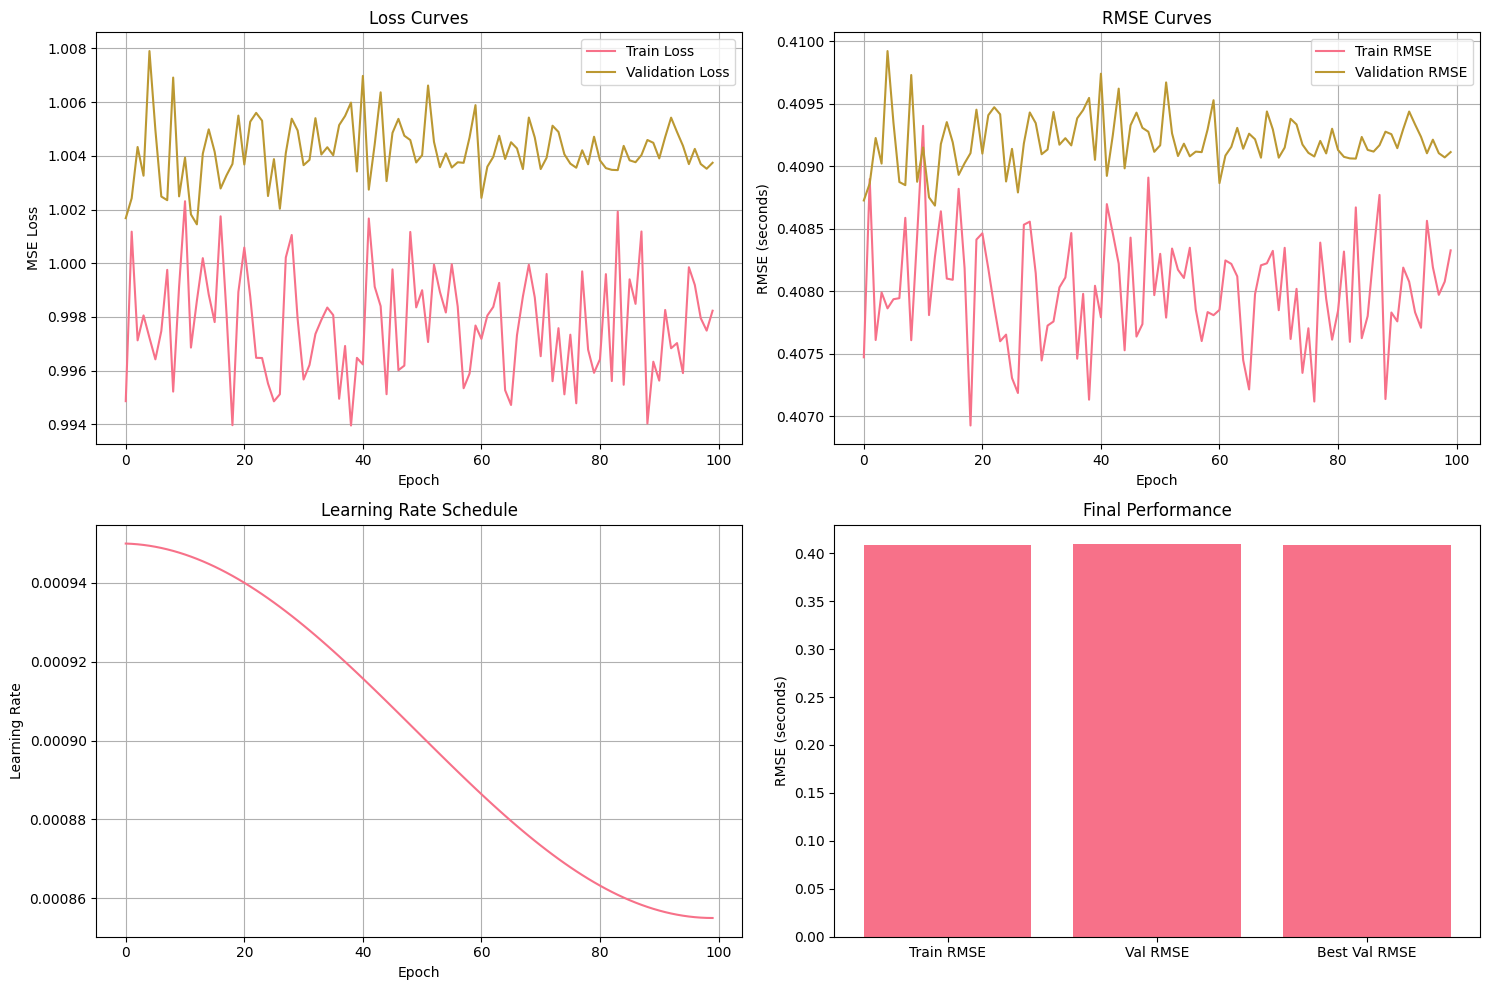

Training Summary:
  Final Train RMSE: 0.4083s
  Final Val RMSE: 0.4091s
  Best Val RMSE: 0.4087s

✅ Training completed successfully!
💡 Next steps:
   - Option [2]: Evaluate your model's competition score
   - Option [3]: Create submission files


In [ ]:
if __name__ == "__main__":
    print("🧠 Challenge 1: EEG-GPT Response Time Prediction")
    print("=" * 60)
    print("This script implements training for predicting response times from EEG data.")
    print("Key features:")
    print("- Multi-Scale Vision Transformer architecture")
    print("- Dataset size options: full, medium (~75%), mini")
    print("- Competition-ready model saving and evaluation")
    print("- Automatic submission file generation")
    print("=" * 60)

    # Choose mode
    print("\n🎛️ CHALLENGE 1 TRAINING OPTIONS")
    print("-" * 40)
    print("[1] Interactive Training Mode (Recommended)")
    print("[2] Competition Score Evaluation")
    print("[3] Create Submission Files")
    print("[4] Exit")

    while True:
        choice = input("\nSelect option [1-4] (default: 1): ").strip()

        if choice in ['', '1']:
            print("🎛️ Starting Interactive Training Mode...")
            results = run_interactive_training(
                task="contrastChangeDetection",
                release="R5"
            )
            if results:
                print("\n✅ Training completed successfully!")
                print("💡 Next steps:")
                print("   - Option [2]: Evaluate your model's competition score")
                print("   - Option [3]: Create submission files")
            break

        elif choice == '2':
            print("🎯 Starting Competition Score Evaluation...")
            results = evaluate_my_trained_model_challenge1()
            if results:
                print("\n✅ Evaluation completed!")
                print("💡 Next step: Option [3] to create submission files")
            break

        elif choice == '3':
            print("📦 Creating Submission Files...")
            success = create_challenge1_submission_files()
            if success:
                print("\n✅ Submission files created successfully!")
                print("💡 Upload the challenge1_submission.zip file to the competition")
            break

        elif choice == '4':
            print("👋 Goodbye!")
            break

        else:
            print("❌ Please enter 1, 2, 3, or 4")

# Competition Score Analysis

In [ ]:
def calculate_competition_score(model, dataloader, dataset, device='cuda'):
    """
    Calculate the exact competition score as per official guidelines

    Score = rmse(y_true, y_pred) / std(y_true)

    Args:
        model: Trained model
        dataloader: DataLoader for evaluation
        dataset: Dataset with denormalization capability
        device: Device to run evaluation on

    Returns:
        dict: Contains competition score, rmse, std, and interpretation
    """
    from sklearn.metrics import root_mean_squared_error as rmse
    from numpy import std
    import numpy as np

    model.eval()
    all_predictions = []
    all_targets = []

    print("🏆 Calculating Competition Score...")

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_x)

            # Denormalize to original scale
            pred_original = dataset.denormalize_predictions(predictions.cpu())
            true_original = dataset.denormalize_predictions(batch_y.cpu())

            all_predictions.extend(pred_original.numpy().flatten())
            all_targets.extend(true_original.numpy().flatten())

    # Convert to numpy arrays
    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)

    # Calculate competition metrics
    competition_rmse = rmse(y_true, y_pred)
    target_std = std(y_true)
    competition_score = competition_rmse / target_std

    # Interpretation
    if competition_score < 0.95:
        interpretation = "🔥 EXCELLENT - Better than random!"
    elif competition_score < 1.0:
        interpretation = "✅ GOOD - Close to random baseline"
    elif competition_score < 1.1:
        interpretation = "⚠️  FAIR - Slightly worse than random"
    else:
        interpretation = "❌ NEEDS WORK - Much worse than random"

    results = {
        'competition_score': competition_score,
        'rmse': competition_rmse,
        'target_std': target_std,
        'interpretation': interpretation,
        'n_samples': len(y_true)
    }

    return results

def load_model_from_checkpoint(checkpoint_path, embed_dim, device='cuda'):
    """Load model from checkpoint file (handles training state)"""
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        print(f"✅ Checkpoint loaded from {checkpoint_path}")

        # Get embed_dim from checkpoint params if available, otherwise use provided
        if 'params' in checkpoint and 'embed_dim' in checkpoint['params']:
            checkpoint_embed_dim = checkpoint['params']['embed_dim']
            print(f"🏗️ Using embed_dim from checkpoint: {checkpoint_embed_dim}")
            embed_dim = checkpoint_embed_dim
        else:
            print(f"🏗️ Using provided embed_dim: {embed_dim}")

        # Create model instance with correct architecture
        model = EEGGPTChallenge1(embed_dim=embed_dim)

        # Load model weights from checkpoint
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()

        # Show checkpoint info
        if 'epoch' in checkpoint:
            print(f"📊 Checkpoint from epoch {checkpoint['epoch']}")
        if 'val_rmse' in checkpoint:
            print(f"📈 Best validation RMSE: {checkpoint['val_rmse']:.4f}")

        return model

    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        return None

def print_competition_score(results):
    """Pretty print competition score results"""
    print("\n" + "="*60)
    print("🏆 COMPETITION SCORE RESULTS")
    print("="*60)
    print(f"📊 Competition Score: {results['competition_score']:.6f}")
    print(f"📈 RMSE: {results['rmse']:.4f}s")
    print(f"📉 Target Std: {results['target_std']:.4f}s")
    print(f"🔢 Samples: {results['n_samples']:,}")
    print(f"💡 {results['interpretation']}")
    print("="*60)

    # Leaderboard context
    print("🏅 LEADERBOARD CONTEXT:")
    print(f"   Current Leader: ~1.002")
    if results['competition_score'] < 1.002:
        print(f"   🎯 YOU'RE WINNING! ({results['competition_score']:.6f} < 1.002)")
    else:
        improvement_needed = results['competition_score'] - 1.002
        print(f"   📈 Need to improve by: {improvement_needed:.6f}")
    print("="*60 + "\n")

def evaluate_model_competition_score(model, train_loader, val_loader, dataset, device='cuda'):
    """Evaluate model on both train and validation with competition scoring"""
    print("🎯 EVALUATING MODEL WITH COMPETITION SCORING")

    # Training score
    print("\n📚 Training Set:")
    train_results = calculate_competition_score(model, train_loader, dataset, device)
    print_competition_score(train_results)

    # Validation score
    print("🔬 Validation Set:")
    val_results = calculate_competition_score(model, val_loader, dataset, device)
    print_competition_score(val_results)

    # Overfitting analysis
    score_gap = val_results['competition_score'] - train_results['competition_score']
    print("🔍 OVERFITTING ANALYSIS:")
    if score_gap < 0.05:
        print(f"   ✅ Good generalization (gap: {score_gap:.4f})")
    elif score_gap < 0.15:
        print(f"   ⚠️  Moderate overfitting (gap: {score_gap:.4f})")
    else:
        print(f"   ❌ Significant overfitting (gap: {score_gap:.4f})")

    return {
        'train': train_results,
        'validation': val_results,
        'overfitting_gap': score_gap
    }

def evaluate_with_random_participant_sampling(model_path, n_iterations=5, dataset_size="medium"):
    """
    Robust evaluation with random participant sampling across multiple iterations

    This provides a better estimate of CodeBench performance by:
    - Using random participant sampling (not fixed seed)
    - Averaging across multiple iterations
    - Using medium dataset size for practical computation
    - Providing confidence intervals

    Args:
        model_path: Path to trained model
        n_iterations: Number of random sampling iterations (default: 5)
        dataset_size: Dataset size to use ("medium" recommended)

    Returns:
        Dict with mean, std, confidence intervals, and individual scores
    """
    import random
    import numpy as np

    print("🎯 ROBUST EVALUATION WITH RANDOM PARTICIPANT SAMPLING")
    print("="*70)
    print(f"📊 Strategy: {n_iterations} iterations of {dataset_size} dataset with random participants")
    print(f"🎲 This simulates CodeBench's unseen participant generalization")
    print("="*70)

    scores = []
    detailed_results = []

    for iteration in range(n_iterations):
        print(f"\n🔄 ITERATION {iteration + 1}/{n_iterations}")
        print("-" * 40)

        # Generate random seed for this iteration
        random_seed = random.randint(0, 100000)
        print(f"🎲 Random seed: {random_seed}")

        try:
            # Load model
            checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
            if 'params' in checkpoint and 'embed_dim' in checkpoint['params']:
                embed_dim = checkpoint['params']['embed_dim']
            else:
                embed_dim = 512  # Default fallback

            model = load_model_from_checkpoint(model_path, embed_dim, 'cuda')
            if model is None:
                print(f"❌ Failed to load model for iteration {iteration + 1}")
                continue

            # Load data with random participant sampling
            # Set random seed for reproducible sampling within this iteration
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)
            random.seed(random_seed)

            dataset, first_raw = load_challenge1_data(
                task="contrastChangeDetection",
                release="R5",
                dataset_size=dataset_size
            )

            if dataset is None:
                print(f"❌ Failed to load dataset for iteration {iteration + 1}")
                continue

            # Preprocess data
            original_sfreq = first_raw.info['sfreq']
            preprocessors = create_competition_preprocessing_pipeline(original_sfreq=original_sfreq, target_sfreq=100)
            preprocessing_success = apply_preprocessing(dataset, preprocessors)

            if not preprocessing_success:
                print(f"❌ Preprocessing failed for iteration {iteration + 1}")
                continue

            # Create windows and labels
            X, y, metadata = create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100)
            if X is None:
                print(f"❌ Windowing failed for iteration {iteration + 1}")
                continue

            # Create dataloaders
            train_loader, val_loader, dataset_obj = create_challenge1_dataloaders(X, y, metadata, batch_size=32)

            # Calculate competition score on validation set
            val_results = calculate_competition_score(model, val_loader, dataset_obj, 'cuda')
            nrmse = val_results['competition_score']

            scores.append(nrmse)
            detailed_results.append({
                'iteration': iteration + 1,
                'random_seed': random_seed,
                'nrmse': nrmse,
                'rmse': val_results['rmse'],
                'target_std': val_results['target_std'],
                'n_samples': val_results['n_samples']
            })

            print(f"✅ NRMSE: {nrmse:.4f} (RMSE: {val_results['rmse']:.4f}, n={val_results['n_samples']})")

        except Exception as e:
            print(f"❌ Error in iteration {iteration + 1}: {e}")
            continue

    if not scores:
        print("❌ No successful iterations - cannot compute statistics")
        return None

    # Calculate statistics
    scores = np.array(scores)
    mean_score = np.mean(scores)
    std_score = np.std(scores, ddof=1)  # Sample standard deviation
    sem_score = std_score / np.sqrt(len(scores))  # Standard error of mean
    ci_95 = 1.96 * sem_score  # 95% confidence interval

    # Results summary
    print("\n" + "="*70)
    print("📊 ROBUST EVALUATION RESULTS")
    print("="*70)
    print(f"🎯 Mean NRMSE: {mean_score:.4f} ± {std_score:.4f}")
    print(f"📈 95% Confidence Interval: [{mean_score - ci_95:.4f}, {mean_score + ci_95:.4f}]")
    print(f"📊 Individual scores: {[f'{s:.4f}' for s in scores]}")
    print(f"🔢 Successful iterations: {len(scores)}/{n_iterations}")

    # CodeBench prediction
    print(f"\n🏆 CODEBENCH PERFORMANCE PREDICTION:")
    if mean_score < 1.0:
        print(f"   ✅ GOOD: Expected to beat random baseline")
    elif mean_score < 1.1:
        print(f"   ⚠️  FAIR: Close to random baseline")
    else:
        print(f"   ❌ NEEDS WORK: Worse than random baseline")

    print(f"   📈 Expected CodeBench range: {mean_score - 2*std_score:.4f} - {mean_score + 2*std_score:.4f}")
    print("="*70)

    return {
        'mean_nrmse': mean_score,
        'std_nrmse': std_score,
        'confidence_interval_95': (mean_score - ci_95, mean_score + ci_95),
        'individual_scores': scores.tolist(),
        'detailed_results': detailed_results,
        'n_successful_iterations': len(scores),
        'n_total_iterations': n_iterations
    }

def evaluate_my_trained_model():
    """
    Evaluate your trained model with competition scoring

    Run this after training to get your competition score!
    """

    model_path = "./models/challenge1_eeg_gpt.pt"

    try:
        # Load checkpoint and determine architecture
        checkpoint = torch.load(model_path, map_location='cpu')

        # Get embed_dim from checkpoint params
        if 'params' in checkpoint and 'embed_dim' in checkpoint['params']:
            embed_dim = checkpoint['params']['embed_dim']
            print(f"🏗️ Model architecture from checkpoint: embed_dim={embed_dim}")
        else:
            # Fallback: try to infer from model weights
            try:
                pos_embed_shape = checkpoint['model_state_dict']['multi_scale_vit.patch_embeddings.0.pos_embed'].shape
                embed_dim = pos_embed_shape[-1]
                print(f"🏗️ Inferred embed_dim from weights: {embed_dim}")
            except:
                # Final fallback
                embed_dim = 512
                print(f"⚠️  Using fallback embed_dim: {embed_dim}")

        # Load model with correct architecture
        model = load_model_from_checkpoint(model_path, embed_dim, 'cuda')
        if model is None:
            return None

        # Load data (same as training)
        dataset, first_raw = load_challenge1_data(task="contrastChangeDetection", release="R5", dataset_size="medium")
        if dataset is None:
            print("❌ Failed to load dataset")
            return None

        # Preprocess data
        original_sfreq = first_raw.info['sfreq']
        preprocessors = create_competition_preprocessing_pipeline(original_sfreq=original_sfreq, target_sfreq=100)
        preprocessing_success = apply_preprocessing(dataset, preprocessors)
        if not preprocessing_success:
            print("❌ Preprocessing failed")
            return None

        # Create windows and labels
        X, y, metadata = create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100)
        if X is None:
            print("❌ Windowing failed")
            return None

        # Create dataloaders
        train_loader, val_loader, dataset = create_challenge1_dataloaders(X, y, metadata, batch_size=32)
        print("✅ Data loaded and preprocessed")

        # Calculate competition scores
        print("\n🎯 CALCULATING COMPETITION SCORES...")
        results = evaluate_model_competition_score(model, train_loader, val_loader, dataset, 'cuda')

        # Final summary
        val_score = results['validation']['competition_score']
        print(f"\n🏆 YOUR FINAL COMPETITION SCORE: {val_score:.6f}")

        if val_score < 1.002:
            print("🎯 CONGRATULATIONS! You're beating the current leader!")
        else:
            print(f"📈 You need to improve by {val_score - 1.002:.6f} to beat the leader")

        return results

    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Make sure you've trained and saved a model first!")
        return None

def evaluate_my_trained_model_challenge1():
    """
    Standalone evaluation function for Challenge 1 trained models

    Run this after training to get your competition score!
    """

    model_path = "./models/challenge1_eeg_gpt.pt"

    try:
        # Load checkpoint and determine architecture
        print("🔍 LOADING TRAINED MODEL...")
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

        # Get embed_dim from checkpoint params
        if 'params' in checkpoint and 'embed_dim' in checkpoint['params']:
            embed_dim = checkpoint['params']['embed_dim']
            print(f"🏗️ Model architecture from checkpoint: embed_dim={embed_dim}")
        else:
            # Fallback: try to infer from model weights
            try:
                pos_embed_shape = checkpoint['model_state_dict']['multi_scale_vit.patch_embeddings.0.pos_embed'].shape
                embed_dim = pos_embed_shape[-1]
                print(f"🏗️ Inferred embed_dim from weights: {embed_dim}")
            except:
                # Final fallback
                embed_dim = 512
                print(f"⚠️  Using fallback embed_dim: {embed_dim}")

        # Load model with correct architecture
        model = load_model_from_checkpoint(model_path, embed_dim, 'cuda')
        if model is None:
            print("❌ Failed to load model")
            return None

        # Load data (same as training)
        dataset, first_raw = load_challenge1_data(
            task="contrastChangeDetection",
            release="R5",
            dataset_size="medium"  # Use medium for better evaluation consistency
        )
        if dataset is None:
            print("❌ Failed to load dataset")
            return None

        # Preprocess data
        original_sfreq = first_raw.info['sfreq']
        preprocessors = create_competition_preprocessing_pipeline(original_sfreq=original_sfreq, target_sfreq=100)
        preprocessing_success = apply_preprocessing(dataset, preprocessors)
        if not preprocessing_success:
            print("❌ Preprocessing failed")
            return None

        # Create windows and labels
        X, y, metadata = create_challenge1_windows(dataset, window_length=2.0, target_sfreq=100)
        if X is None:
            print("❌ Windowing failed")
            return None

        # Create dataloaders
        train_loader, val_loader, dataset = create_challenge1_dataloaders(X, y, metadata, batch_size=32)
        print("✅ Data loaded and preprocessed")

        # Calculate competition scores
        print("\n🎯 CALCULATING COMPETITION SCORES...")
        results = evaluate_model_competition_score(model, train_loader, val_loader, dataset, 'cuda')

        # Final summary
        val_score = results['validation']['competition_score']
        print(f"\n🏆 YOUR FINAL CHALLENGE 1 COMPETITION SCORE: {val_score:.6f}")

        if val_score < 1.002:
            print("🎯 CONGRATULATIONS! You're beating the current leader!")
        else:
            print(f"📈 You need to improve by {val_score - 1.002:.6f} to beat the leader")

        return results

    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Make sure you've trained and saved a model first!")
        import traceback
        traceback.print_exc()
        return None

def create_challenge1_submission_files(output_dir="./submission"):
    """
    Create preliminary submission files for Challenge 1

    Creates:
    - preliminary_submission_challenge1.py (model definition with exact hyperparameters)
    - weights_challenge_1.pt (model weights)
    - challenge1_submission.zip (temporary package for testing)
    """
    import os
    import shutil
    import zipfile

    # Detect Colab environment
    try:
        import google.colab
        in_colab = True
        if output_dir == "./submission":
            output_dir = "/content/submission"
            print(f"🔍 Colab environment detected, using output directory: {output_dir}")
    except ImportError:
        in_colab = False

    # Print environment info
    print(f"🔍 Current working directory: {os.getcwd()}")
    print(f"🔍 Output directory: {output_dir}")

    model_path = "./models/challenge1_eeg_gpt.pt"

    try:
        # Check if model exists
        if not os.path.exists(model_path):
            print(f"❌ Model not found at {model_path}")
            print("💡 Please train a model first using the interactive training!")
            return False

        # Load checkpoint to get hyperparameters
        print("🔍 Reading model hyperparameters...")
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

        # Extract hyperparameters
        if 'params' in checkpoint:
            hyperparams = checkpoint['params']
            print(f"✅ Found hyperparameters: {hyperparams}")
        else:
            # Create default hyperparameters
            hyperparams = {
                'embed_dim': 512,
                'num_layers': 8,
                'num_heads': 8,
                'patch_sizes': [32, 16, 8]
            }
            print(f"⚠️  Using default hyperparameters: {hyperparams}")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Create preliminary submission file with exact hyperparameters from training
        preliminary_submission_code = f'''"""
Challenge 1 Preliminary Submission File - Response Time Prediction
==================================================================

This file contains the Challenge 1 model architecture with EXACT hyperparameters from training.
Generated automatically from training session.

Training Hyperparameters Used:
- embed_dim: {hyperparams['embed_dim']}
- num_layers: {hyperparams.get('num_layers', 8)}
- num_heads: {hyperparams.get('num_heads', 8)}
- patch_sizes: {hyperparams.get('patch_sizes', [32, 16, 8])}
- model_architecture: {hyperparams.get('model_architecture', 'transformer_vit')}

Requirements:
- Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
- Output: (batch_size,) - response time prediction (scalar)
- Model must fit in 20GB GPU memory
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce
import numpy as np

class MultiScaleViT(nn.Module):
    """Multi-Scale Vision Transformer for EEG Analysis"""

    def __init__(self, n_channels=129, n_timepoints=200, embed_dim={hyperparams['embed_dim']},
                 num_layers={hyperparams.get('num_layers', 8)}, num_heads={hyperparams.get('num_heads', 8)},
                 patch_sizes={hyperparams.get('patch_sizes', [32, 16, 8])}):
        super().__init__()

        self.patch_sizes = patch_sizes
        self.embed_dim = embed_dim

        # Multi-scale patch embeddings
        self.patch_embeddings = nn.ModuleList([
            self._create_patch_embedding(patch_size, n_channels, n_timepoints, embed_dim)
            for patch_size in patch_sizes
        ])

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head for response time prediction
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            nn.Linear(embed_dim // 4, 1)
        )

    def _create_patch_embedding(self, patch_size, n_channels, n_timepoints, embed_dim):
        """Create patch embedding for given patch size"""
        return nn.Sequential(
            nn.Conv2d(1, embed_dim, kernel_size=(n_channels, patch_size), stride=(1, patch_size)),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1, None)),
            nn.Flatten(start_dim=2),
        )

    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timepoints)
        batch_size = x.shape[0]

        # Add channel dimension for conv2d: (batch_size, 1, n_channels, n_timepoints)
        x = x.unsqueeze(1)

        # Multi-scale feature extraction
        patch_features = []
        for patch_embedding in self.patch_embeddings:
            features = patch_embedding(x)
            features = features.transpose(-1, -2)  # (batch_size, seq_len, embed_dim)
            patch_features.append(features)

        # Concatenate multi-scale features
        x = torch.cat(patch_features, dim=1)  # (batch_size, total_seq_len, embed_dim)

        # Add positional encoding
        seq_len = x.shape[1]
        pos_embed = nn.Parameter(torch.randn(1, seq_len, self.embed_dim) * 0.02)
        if not hasattr(self, 'pos_embed'):
            self.register_parameter('pos_embed', pos_embed)
        x = x + self.pos_embed[:, :seq_len, :]

        # Transformer encoding
        x = self.transformer(x)

        # Global average pooling
        x = x.mean(dim=1)  # (batch_size, embed_dim)

        # Regression prediction
        predictions = self.regression_head(x)  # (batch_size, 1)

        return predictions  # (batch_size, 1) - CodeBench expects 2D output

class PreliminarySubmissionChallenge1:
    """
    Preliminary submission class for Challenge 1 ONLY
    This will be merged with Challenge 2 to create the final submission
    """

    def __init__(self, SFREQ, DEVICE):
        """Initialize Challenge 1 model with competition interface"""
        self.sfreq = SFREQ
        self.device = DEVICE
        print(f"🎯 Challenge 1 Model Initialized (Sampling Rate: {{SFREQ}} Hz, Device: {{DEVICE}})")

    def get_model_challenge_1(self):
        """
        Returns model for Challenge 1: Response time prediction

        Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
        Output: (batch_size,) - response time prediction (scalar)
        """
        print("🎯 Loading Challenge 1 Model (Response Time Prediction)...")

        # Create model with EXACT hyperparameters from training
        model = MultiScaleViT(
            n_channels=129,
            n_timepoints=200,
            embed_dim={hyperparams['embed_dim']},
            num_layers={hyperparams.get('num_layers', 8)},
            num_heads={hyperparams.get('num_heads', 8)},
            patch_sizes={hyperparams.get('patch_sizes', [32, 16, 8])}
        ).to(self.device)

        # Load trained weights - competition system expects this path
        weights_path = '/app/output/weights_challenge_1.pt'
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device))
            model.eval()
            print(f"   ✅ Challenge 1 model loaded successfully from {{weights_path}}")
        except Exception as e:
            print(f"   ⚠️ Warning: Could not load weights from {{weights_path}}: {{e}}")
            # For local testing, try current directory
            try:
                local_weights_path = 'weights_challenge_1.pt'
                model.load_state_dict(torch.load(local_weights_path, map_location=self.device))
                model.eval()
                print(f"   ✅ Challenge 1 model loaded from local path: {{local_weights_path}}")
            except Exception as e2:
                print(f"   🔄 Model initialized with random weights for testing")

        return model

# Hyperparameters used for this model (for consolidation script)
CHALLENGE1_HYPERPARAMS = {hyperparams}
'''

        # Write preliminary submission file
        preliminary_submission_path = os.path.join(output_dir, "preliminary_submission_challenge1.py")
        with open(preliminary_submission_path, 'w') as f:
            f.write(preliminary_submission_code)
        print(f"✅ Created preliminary_submission_challenge1.py with exact hyperparameters")

        # Copy model weights
        weights_dest = os.path.join(output_dir, "weights_challenge_1.pt")

        # Extract only the model state dict (not the full checkpoint)
        model_state_dict = checkpoint['model_state_dict']
        torch.save(model_state_dict, weights_dest)
        print(f"✅ Created weights_challenge_1.pt")

        # Create placeholder for Challenge 2 weights (required for submission)
        weights_challenge2_dest = os.path.join(output_dir, "weights_challenge_2.pt")
        if not os.path.exists(weights_challenge2_dest):
            # Create a dummy tensor as placeholder
            dummy_weights = {}
            torch.save(dummy_weights, weights_challenge2_dest)
            print(f"✅ Created placeholder weights_challenge_2.pt")

        # Create preliminary zip file for testing (Challenge 1 only)
        zip_path = os.path.join(output_dir, "challenge1_preliminary.zip")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add files with no directory structure (single level)
            zipf.write(preliminary_submission_path, "preliminary_submission_challenge1.py")
            zipf.write(weights_dest, "weights_challenge_1.pt")

        print(f"✅ Created preliminary zip: {zip_path}")

        # List created files with absolute paths for easy location
        abs_output_dir = os.path.abspath(output_dir)
        print(f"\n📁 CHALLENGE 1 PRELIMINARY FILES CREATED:")
        print(f"📂 Output directory: {abs_output_dir}")
        print(f"📄 preliminary_submission_challenge1.py: {os.path.abspath(preliminary_submission_path)}")
        print(f"⚖️  weights_challenge_1.pt: {os.path.abspath(weights_dest)}")
        print(f"📦 challenge1_preliminary.zip: {os.path.abspath(zip_path)}")
        print(f"\n💡 Next: Run Challenge 2 to consolidate both models into final submission")

        # In Colab, also list files in the output directory for verification
        if in_colab:
            print(f"\n📋 Files in {output_dir}:")
            for file in os.listdir(output_dir):
                file_path = os.path.join(output_dir, file)
                size = os.path.getsize(file_path)
                print(f"   {file} ({size:,} bytes)")

        return True

    except Exception as e:
        print(f"❌ Error creating submission files: {e}")
        import traceback
        traceback.print_exc()
        return False

In [ ]:


# COMPETITION SCORE ANALYSIS - STANDALONE SECTION
# ================================================
# Copy and run this section separately in Colab to evaluate your trained model

# Run this after training to get your competition score
results = evaluate_my_trained_model_challenge1()

if results:
    val_score = results['validation']['competition_score']
    print(f"\n🏆 YOUR CHALLENGE 1 COMPETITION SCORE: {val_score:.6f}")

    # Interpretation
    if val_score < 1.002:
        print("🎯 EXCELLENT! You're beating the current leaderboard!")
    elif val_score < 1.01:
        print("🎯 VERY GOOD! You're competitive!")
    elif val_score < 1.05:
        print("📈 GOOD! Getting close to competitive range")
    else:
        print("📈 Keep improving! Try different hyperparameters")

    print(f"\n📊 DETAILED RESULTS:")
    print(f"Train Score: {results['train']['competition_score']:.6f}")
    print(f"Validation Score: {results['validation']['competition_score']:.6f}")
    print(f"Overfitting Gap: {results['overfitting_gap']:.6f}")



🔍 LOADING TRAINED MODEL...
🏗️ Model architecture from checkpoint: embed_dim=4
✅ Checkpoint loaded from ./models/challenge1_eeg_gpt.pt
🏗️ Using embed_dim from checkpoint: 4
🔧 Fixing position embedding initialization: PatchEmbedding
🔧 Fixing position embedding initialization: PatchEmbedding
✅ Weight initialization complete!
   - Position embeddings: std=0.02 (was std=1.0)
   - Linear layers: Xavier uniform
   - Conv layers: Kaiming normal
📊 Checkpoint from epoch 12
📈 Best validation RMSE: 0.4087

LOADING CHALLENGE 1 DATA
🔧 Debug: dataset_size = mini
🔬 Using mini dataset for testing...
✅ Dataset loaded: 60 recordings


📊 Data specs:
   Channels: 129
   Original sampling rate: 100.0 Hz
   Duration: 349.0 seconds

🔍 DATA VALIDATION:
   Task: contrastChangeDetection
   Release: R5
   Dataset size: mini
   ✅ Annotations found: 75 events
   📋 Event types in first recording: ['9999', 'break cnt', 'contrastChangeB1_start', 'contrastTrial_start', 'left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']
   🎯 Challenge 1 validation:
      Stimulus events: YES - True
      Response events: YES - True

CREATING PREPROCESSING PIPELINE
Original sampling rate: 100.0 Hz
Target sampling rate: 100 Hz (Competition Standard)
----------------------------------------
📊 Already at target sampling rate - simplified preprocessing
   ⚠️  60Hz notch filter NOT applicable (above Nyquist)

Pipeline created:
  1. filter: {'l_freq': 0.5, 'h_freq': 48.0, 'verbose': False}
  2. set_eeg_reference: {'ref_channels': 'average', 'verbose': False}

📊 Frequency Analysis:
   Original Nyquist frequency: 50.0 Hz
   Target Nyqui

✅ Preprocessing complete:
   Final sampling rate: 100.0 Hz
   Final shape: (129, 34900)

CREATING CHALLENGE 1 WINDOWS

Processing recording 1:
  Duration: 349.0s, Sampling rate: 100.0Hz
  Found 50 potential stimulus events
  Found 46 potential response events
  Stimulus event types: ['contrastChangeB1_start', 'contrastTrial_start', 'left_target', 'right_target']
  Response event types: ['left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']
  Filtering to 24 target events and 22 button press events
  ✅ Successfully paired 22 stimulus-response events
  📊 Response time range: 1.220 - 2.600s
  📊 Mean response time: 1.868s
Available event types: ['9999', 'break cnt', 'contrastChangeB1_start', 'contrastTrial_start', 'left_buttonPress', 'left_target', 'right_buttonPress', 'right_target']

Processing recording 2:
  Duration: 401.0s, Sampling rate: 100.0Hz
  Found 51 potential stimulus events
  Found 46 potential response events
  Stimulus event types: ['contrastChangeB2_start

#Submission Export

In [ ]:


# SUBMISSION EXPORT - STANDALONE SECTION
# =======================================
# Copy and run this section separately in Colab to create submission files

# Create submission files for the competition
success = create_challenge1_submission_files()

if success:
    print("\n🎯 SUBMISSION READY!")
    print("\n📋 SUBMISSION CHECKLIST:")
    print("✅ submission.py created with model architecture")
    print("✅ weights_challenge_1.pt contains your trained model")
    print("✅ challenge1_submission.zip ready for upload")
    print("\n💡 NEXT STEPS:")
    print("1. Download the challenge1_submission.zip file")
    print("2. Upload to the competition platform")
    print("3. Check your leaderboard position!")
else:
    print("❌ Submission creation failed. Make sure you have a trained model!")




🔍 Colab environment detected, using output directory: /content/submission
🔍 Current working directory: /content
🔍 Output directory: /content/submission
🔍 Reading model hyperparameters...
✅ Found hyperparameters: {'dataset_size': 'medium', 'mini': False, 'batch_size': 128, 'model_architecture': 'transformer_vit', 'embed_dim': 4, 'training_mode': 'manual_epochs', 'num_epochs': 100, 'learning_rate': 0.00095, 'use_weight_decay': True, 'weight_decay': 0.0001, 'use_cross_validation': False, 'cv_folds': 1, 'log_verbosity': 'sparse', 'log_frequency': 2, 'monitor_gradients': False, 'gradient_verbose': True}
✅ Created preliminary_submission_challenge1.py with exact hyperparameters
✅ Created weights_challenge_1.pt
✅ Created placeholder weights_challenge_2.pt
✅ Created preliminary zip: /content/submission/challenge1_preliminary.zip

📁 CHALLENGE 1 PRELIMINARY FILES CREATED:
📂 Output directory: /content/submission
📄 preliminary_submission_challenge1.py: /content/submission/preliminary_submission_cha